In [3]:
from scipy.special import erf
from scipy.ndimage import laplace
print("Scipy imports successful")

import nibabel as nib
print("Nibabel imports successful")

from tqdm import tqdm
import logging
from pathlib import Path
import pandas as pd
import numpy as np
print("Training Phase Visualization and data writers imports successful")

import random
import copy
import re
import os
print("Other supplies successful")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MaxPool2d
import torch.nn.functional as F
print("Torch supplies successful")

import torchvision
print("Line 1 supplies successful")

from torchvision import transforms
print("Line 2 supplies successful")

import torchvision.transforms.functional as TF
print("Line 3 supplies successful")


print("Torchvision imports successful")

def dice_coeff(input: torch.Tensor, target: torch.Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: torch.Tensor, target: torch.Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: torch.Tensor, target: torch.Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handle padding if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)      # (B, 64, H, W)
        x2 = self.down1(x1)   # (B, 128, H/2, W/2)
        x3 = self.down2(x2)   # (B, 256, H/4, W/4)
        x4 = self.down3(x3)   # (B, 512, H/8, W/8)
        x5 = self.down4(x4)   # (B, 1024, H/16, W/16)
        x = self.up1(x5, x4)  # (B, 512, H/8, W/8)
        x = self.up2(x, x3)   # (B, 256, H/4, W/4)
        x = self.up3(x, x2)   # (B, 128, H/2, W/2)
        x = self.up4(x, x1)   # (B, 64, H, W)
        logits = self.outc(x) # (B, n_classes, H, W)
        return logits

def Img_proc(image, _lambda=-0.8, epsilon=1e-6):
        """
        Image processing function with safeguards for invalid input values.
        """
        if np.isnan(image).any() or np.isinf(image).any():
            raise ValueError("Input image contains NaN or infinity values.")
        
        I_img = image
        min_val = np.min(I_img)
        max_val = np.max(I_img)
        
        if max_val == min_val:
            return np.zeros_like(I_img)  
        
        I_img_norm = (I_img - min_val) / (max_val - min_val + epsilon)
        
        max_I_img = np.max(I_img_norm)
        IMG1 = (max_I_img / np.log(max_I_img + 1 + epsilon)) * np.log(I_img_norm + 1)
        IMG2 = 1 - np.exp(-I_img_norm)
        IMG3 = (IMG1 + IMG2) / (_lambda + (IMG1 * IMG2))
        IMG4 = erf(_lambda * np.arctan(np.exp(IMG3)) - 0.5 * IMG3)
        
    
        min_IMG4 = np.min(IMG4)
        max_IMG4 = np.max(IMG4)
        if max_IMG4 == min_IMG4:
            return np.zeros_like(IMG4) 
        
        IMG5 = (IMG4 - min_IMG4) / (max_IMG4 - min_IMG4 + epsilon)
        
        return IMG5

class BrainSegmentationDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        """
        Args:
            csv_path (str): Path to the CSV file with data details.
            transform (callable, optional): Optional transforms to be applied on a sample.
        """
        self.data_summary = pd.read_csv(csv_path)
        self.subjects = self.data_summary['Subject ID'].unique()
        self.transform = transform
        self.slice_info = self._create_slice_index()

    def Img_proc(image, _lambda=-0.8, epsilon=1e-6):
        """
        Image processing function with safeguards for invalid input values.
        """
        if np.isnan(image).any() or np.isinf(image).any():
            raise ValueError("Input image contains NaN or infinity values.")
        
        I_img = image
        min_val = np.min(I_img)
        max_val = np.max(I_img)
        
        if max_val == min_val:
            return np.zeros_like(I_img)  
        
        I_img_norm = (I_img - min_val) / (max_val - min_val + epsilon)
        
        max_I_img = np.max(I_img_norm)
        IMG1 = (max_I_img / np.log(max_I_img + 1 + epsilon)) * np.log(I_img_norm + 1)
        IMG2 = 1 - np.exp(-I_img_norm)
        IMG3 = (IMG1 + IMG2) / (_lambda + (IMG1 * IMG2))
        IMG4 = erf(_lambda * np.arctan(np.exp(IMG3)) - 0.5 * IMG3)
        
    
        min_IMG4 = np.min(IMG4)
        max_IMG4 = np.max(IMG4)
        if max_IMG4 == min_IMG4:
            return np.zeros_like(IMG4) 
        
        IMG5 = (IMG4 - min_IMG4) / (max_IMG4 - min_IMG4 + epsilon)
        
        return IMG5

    
    def _create_slice_index(self):
        """Create a list of (subject_id, slice_idx) pairs."""
        slice_info = []
        for subject_id in self.subjects:
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            flair_path = subject_data[subject_data['Scan Type'] == 'flair']['File Path'].values[0]
            nii = nib.load(flair_path)
            depth = nii.shape[2]  # Assume all modalities have the same depth
            slice_info.extend([(subject_id, z) for z in range(depth)])
        return slice_info

    def __len__(self):
        return len(self.slice_info)
        
    
        
    def __getitem__(self, idx):
        subject_id, slice_idx = self.slice_info[idx]
        subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]

        # Load input modalities
        modalities = ['flair', 't1', 't1ce', 't2']
        slices = []
        for modality in modalities:
            file_path = subject_data[subject_data['Scan Type'] == modality]['File Path'].values[0]
            nii = nib.load(file_path)
            image = nii.get_fdata().astype(np.float32)
            image = (image - np.mean(image)) / np.std(image)  # Normalize
            image = Img_proc(image)
            slices.append(image[:, :, slice_idx])  # Extract 2D slice

        # Stack modalities into a single tensor (C x H x W)
        images = np.stack(slices, axis=0)
        # Check for missing segmentation mask
        seg_data = subject_data[subject_data['Scan Type'] == 'seg']
        if seg_data.empty:
            raise ValueError(f"Missing segmentation mask for subject {subject_id}")
        seg_path = seg_data['File Path'].values[0]
        seg_nii = nib.load(seg_path)
        seg_mask = seg_nii.get_fdata().astype(np.uint8)
        
        # Remap labels: 4 -> 3
        seg_mask[seg_mask == 4] = 3
        seg_slice = seg_mask[:, :, slice_idx]  # Extract 2D slice

        # Apply transforms if specified
        if self.transform:
            images, seg_slice = self.transform(images, seg_slice)

        return torch.tensor(images, dtype=torch.float32), torch.tensor(seg_slice, dtype=torch.long)


import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader

'''
class BrainSegmentationDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        """
        Args:
            csv_path (str): Path to the CSV file with data details.
            transform (callable, optional): Optional transforms to be applied on a sample.
        """
        self.data_summary = pd.read_csv(csv_path)
        self.subjects = self.data_summary['Subject ID'].unique()
        self.transform = transform

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject_id = self.subjects[idx]
        subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]

        # Load input modalities
        modalities = ['flair', 't1', 't1ce', 't2']
        images = []
        for modality in modalities:
            file_path = subject_data[subject_data['Scan Type'] == modality]['File Path'].values[0]
            nii = nib.load(file_path)
            image = nii.get_fdata().astype(np.float32)
            image = (image - np.mean(image)) / np.std(image)  # Normalize
            images.append(image)

        # Stack modalities into a single tensor (C x H x W)
        images = np.stack(images, axis=0)

        # Load segmentation mask
        seg_path = subject_data[subject_data['Scan Type'] == 'seg']['File Path'].values[0]
        seg_nii = nib.load(seg_path)
        seg_mask = seg_nii.get_fdata().astype(np.uint8)

        # Apply transforms if specified
        if self.transform:
            images, seg_mask = self.transform(images, seg_mask)

        return torch.tensor(images), torch.tensor(seg_mask)
'''
# Initialize the dataset and dataloader
csv_path = '../data/selected_test_subject.csv'
dataset = BrainSegmentationDataset(csv_path)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Example: Inspect a batch
for batch_idx, (images, masks) in enumerate(dataloader):
    print(f"Batch {batch_idx+1}")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    break

def train_model(
    model,
    dataset,
    device,
    epochs: int = 5,
    batch_size: int = 1,
    learning_rate: float = 1e-5,
    val_percent: float = 0.1,
    save_checkpoint: bool = True,
    amp: bool = False,
    weight_decay: float = 1e-8,
    momentum: float = 0.999,
    gradient_clipping: float = 1.0,
    pin_memory=False,
    checkpoint_dir: str = "./checkpoints"
):
    
    # 1. Split dataset into training and validation sets
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 2. Create DataLoader objects
    loader_args = dict(batch_size=batch_size, num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # 3. Initialize optimizer, loss function, and AMP scaler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()

    # 4. Training loop
    logging.info(f"Starting training for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
            for images, masks in train_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)

                # Forward pass
                with torch.cuda.amp.autocast(enabled=amp):
                    predictions = model(images)
                    if model.n_classes == 1:
                        loss = criterion(predictions.squeeze(1), masks.float())
                        loss += dice_loss(torch.sigmoid(predictions.squeeze(1)), masks.float(), multiclass=False)
                    else:
                        loss = criterion(predictions, masks)
                        loss += dice_loss(
                            torch.softmax(predictions, dim=1),
                            torch.nn.functional.one_hot(masks, num_classes=model.n_classes)
                                .permute(0, 3, 1, 2)
                                .float(),
                            multiclass=True
                        )

                # Backward pass
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(1)
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        logging.info(f"Epoch {epoch} - Training loss: {epoch_loss:.4f}")

        # Validation loop
        val_score = evaluate(model, val_loader, device, amp)
        logging.info(f"Epoch {epoch} - Validation Dice Score: {val_score:.4f}")

        # Save checkpoint
        if save_checkpoint:
            checkpoint_path = Path(checkpoint_dir)
            checkpoint_path.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path / f"checkpoint_epoch{epoch}.pth")
            logging.info(f"Checkpoint saved at epoch {epoch}")

def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)


Scipy imports successful
Nibabel imports successful
Training Phase Visualization and data writers imports successful
Other supplies successful
PyTorch version: 2.5.0
CUDA available: True
CUDA version: 12.1
Torch supplies successful
Line 1 supplies successful
Line 2 supplies successful
Line 3 supplies successful
Torchvision imports successful
Batch 1
Images shape: torch.Size([4, 4, 240, 240])
Masks shape: torch.Size([4, 240, 240])


In [4]:
device = torch.device('cuda')
dataset = BrainSegmentationDataset(csv_path="../data/selected_test_subject.csv")

model = UNet(n_channels=4, n_classes=4)  # Adjust based on your data
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [6]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# File paths
checkpoint_path = "../model/model.pth"
csv_path = "../data/selected_test_subject - Copy.csv"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = BrainSegmentationDataset(csv_path)
loader_args = dict(batch_size=1, num_workers=0, pin_memory=True)
data_loader = DataLoader(dataset, shuffle=False, **loader_args)

'''
import torch
from torch.utils.data import DataLoader

# Assuming you've already defined your dataset and data_loader
for batch_idx, (data, target) in enumerate(data_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data:", data)
    print("Target:", target)
    # If you only want to inspect the first few batches, uncomment the next line
    # if batch_idx == 4:  # For example, first 5 batches
    #     break
'''

'\nimport torch\nfrom torch.utils.data import DataLoader\n\n# Assuming you\'ve already defined your dataset and data_loader\nfor batch_idx, (data, target) in enumerate(data_loader):\n    print(f"Batch {batch_idx + 1}:")\n    print("Data:", data)\n    print("Target:", target)\n    # If you only want to inspect the first few batches, uncomment the next line\n    # if batch_idx == 4:  # For example, first 5 batches\n    #     break\n'

In [7]:

# Evaluation function
def evaluate(net, dataloader, device, amp=False):
    net.eval()
    num_val_batches = len(dataloader)
    results = []
    score = 0

    # Iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for idx, batch in enumerate(tqdm(dataloader, total=num_val_batches, desc="Validation", unit="batch", leave=False)):
            image, mask_true = batch

            # Move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # Predict the mask
            mask_pred = net(image)
            preds = torch.argmax(mask_pred, dim=1)  # Shape: (B, H, W)
            #print(preds.shape)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, "True mask indices should be in [0, 1]"
                mask_pred = (torch.sigmoid(mask_pred) > 0.5).float()
                # Compute the Dice score
                dice_score = dice_coeff(mask_pred, mask_true, reduce_batch_first=False).item()
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, "True mask indices should be in [0, n_classes]"
                # Convert to one-hot format
                mask_true = torch.nn.functional.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = torch.nn.functional.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # Compute the Dice score, ignoring background
                dice_score = multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False).item()

            results.append({"Index": idx, "Dice Score": dice_score})
            score += dice_score

    # Save results
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="Dice Score", ascending=True)
    output_path = Path("../exp/validation_results.csv")
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

    return score, results

# Perform validation for all checkpoints in the directory
checkpoint_dir = "../model"  # Set your checkpoint directory path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Iterate through all files in the checkpoint directory
for checkpoint_file in os.listdir(checkpoint_dir):
    if checkpoint_file.endswith(".pt") or checkpoint_file.endswith(".pth"):  # Adjust based on your file extension
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        print(checkpoint_path)
        # Load the model
        model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device)  # Adjust based on your dataset
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        
        # Evaluate the model
        avg_dice_score, results = evaluate(model, data_loader, device, amp=False)
        
        # Print the results
        print(f"Checkpoint: {checkpoint_file}")
        print(f"Average Dice Score: {avg_dice_score:.4f}")
        print(results)  # Optionally, print the detailed results
        print("-" * 50)


C:\Users\FEI\AppData\Local\Temp\ipykernel_35312\4253210135.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

../model\model.pth


Results saved to ..\exp\validation_results.csv
Checkpoint: model.pth
Average Dice Score: 138.4433
[{'Index': 0, 'Dice Score': 1.0}, {'Index': 1, 'Dice Score': 1.0}, {'Index': 2, 'Dice Score': 1.0}, {'Index': 3, 'Dice Score': 1.0}, {'Index': 4, 'Dice Score': 1.0}, {'Index': 5, 'Dice Score': 1.0}, {'Index': 6, 'Dice Score': 1.0}, {'Index': 7, 'Dice Score': 1.0}, {'Index': 8, 'Dice Score': 1.0}, {'Index': 9, 'Dice Score': 1.0}, {'Index': 10, 'Dice Score': 1.0}, {'Index': 11, 'Dice Score': 1.0}, {'Index': 12, 'Dice Score': 1.0}, {'Index': 13, 'Dice Score': 1.0}, {'Index': 14, 'Dice Score': 1.0}, {'Index': 15, 'Dice Score': 1.0}, {'Index': 16, 'Dice Score': 1.0}, {'Index': 17, 'Dice Score': 1.0}, {'Index': 18, 'Dice Score': 1.0}, {'Index': 19, 'Dice Score': 1.0}, {'Index': 20, 'Dice Score': 1.0}, {'Index': 21, 'Dice Score': 1.0}, {'Index': 22, 'Dice Score': 1.0}, {'Index': 23, 'Dice Score': 1.0}, {'Index': 24, 'Dice Score': 0.6666667461395264}, {'Index': 25, 'Dice Score': 0.6666666865348816

In [ ]:
results_df

C:\Users\FEI\AppData\Local\Temp\ipykernel_35312\1930120665.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

Visualizing sample at index 151 (Dice Score: 1.0000)
Index: 151, Ground Truth Sum: 0, Prediction Sum: 0


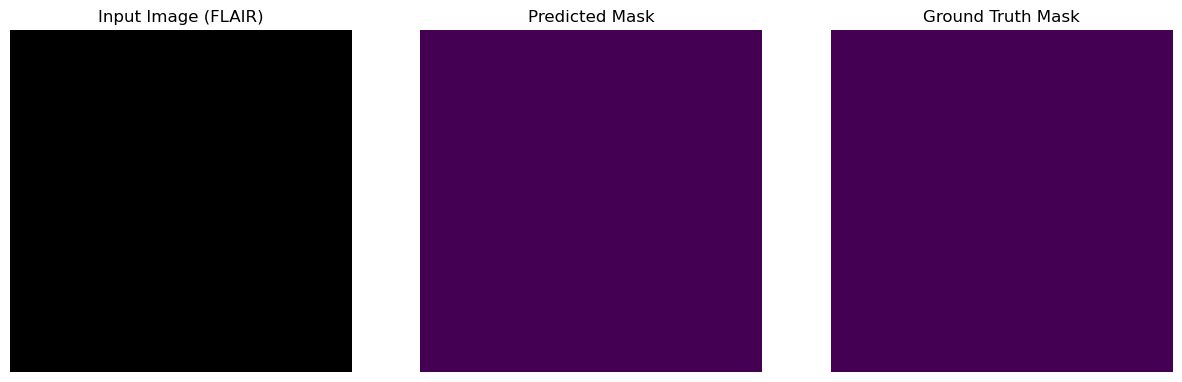

Visualizing sample at index 152 (Dice Score: 1.0000)
Index: 152, Ground Truth Sum: 0, Prediction Sum: 0


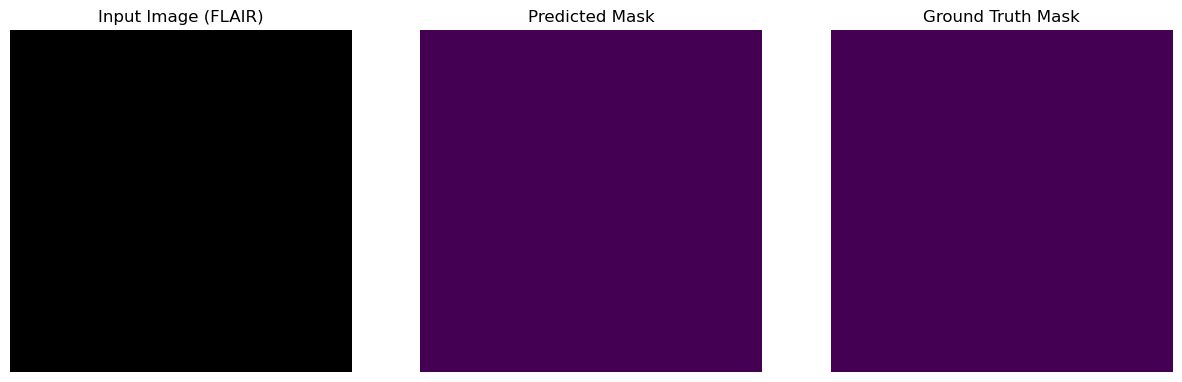

Visualizing sample at index 130 (Dice Score: 1.0000)
Index: 130, Ground Truth Sum: 0, Prediction Sum: 0


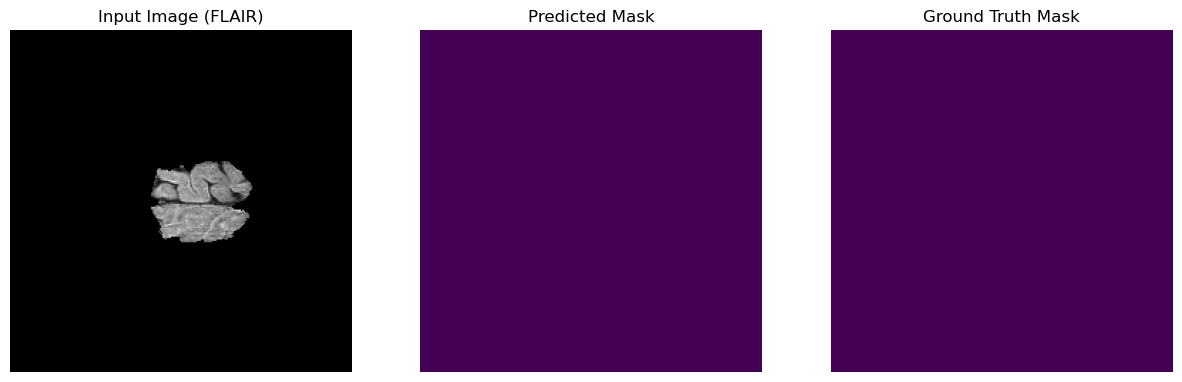

Visualizing sample at index 149 (Dice Score: 1.0000)
Index: 149, Ground Truth Sum: 0, Prediction Sum: 0


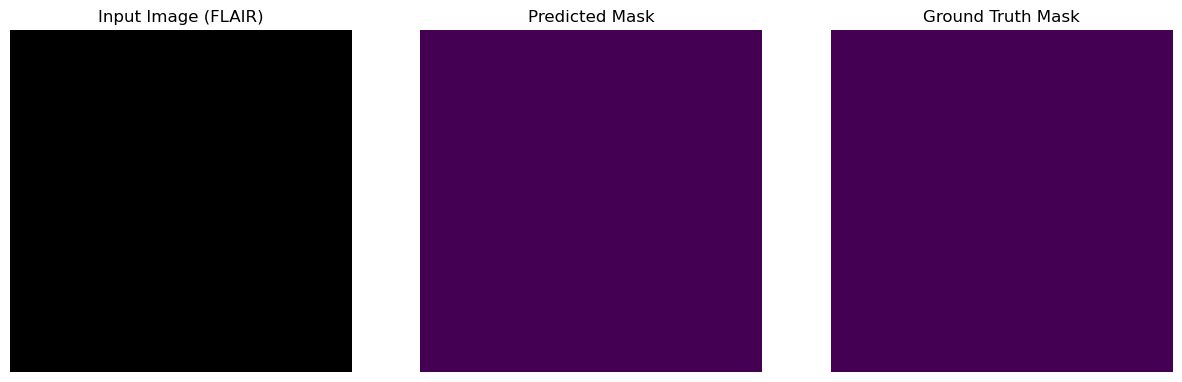

Visualizing sample at index 132 (Dice Score: 1.0000)
Index: 132, Ground Truth Sum: 0, Prediction Sum: 0


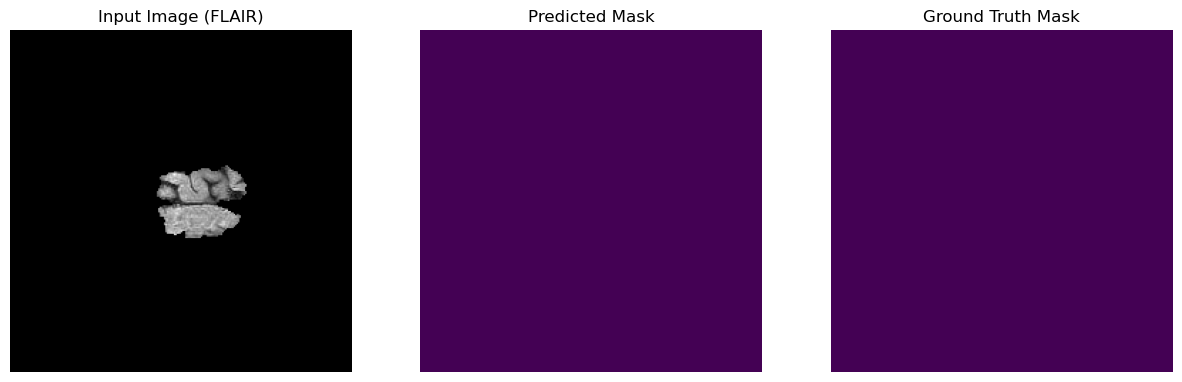

Visualizing sample at index 133 (Dice Score: 1.0000)
Index: 133, Ground Truth Sum: 0, Prediction Sum: 0


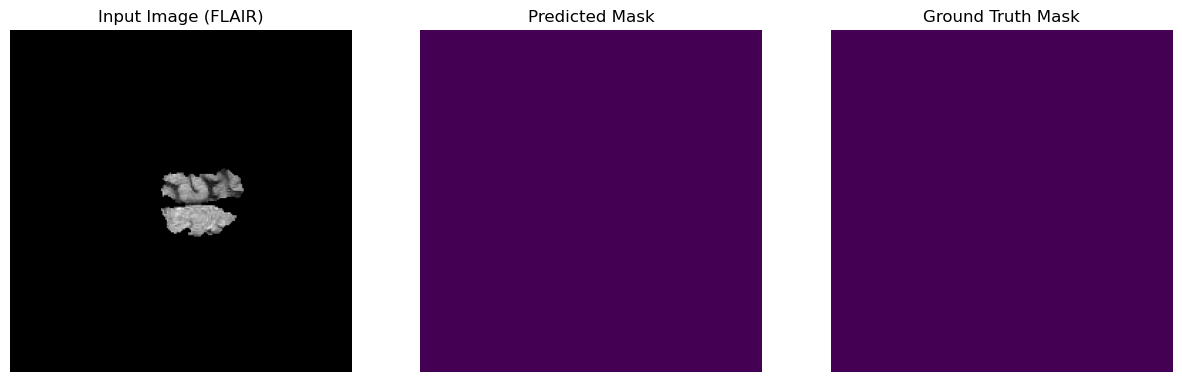

Visualizing sample at index 134 (Dice Score: 1.0000)
Index: 134, Ground Truth Sum: 0, Prediction Sum: 0


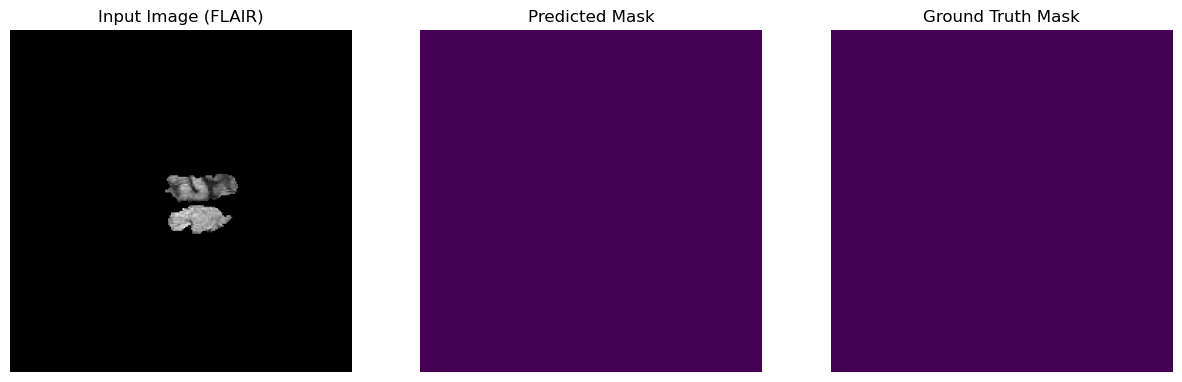

Visualizing sample at index 129 (Dice Score: 1.0000)
Index: 129, Ground Truth Sum: 0, Prediction Sum: 0


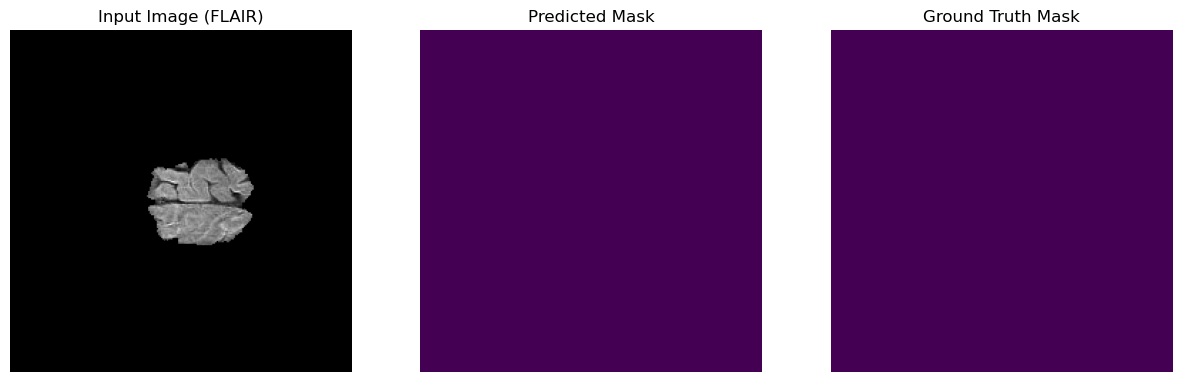

Visualizing sample at index 128 (Dice Score: 1.0000)
Index: 128, Ground Truth Sum: 0, Prediction Sum: 0


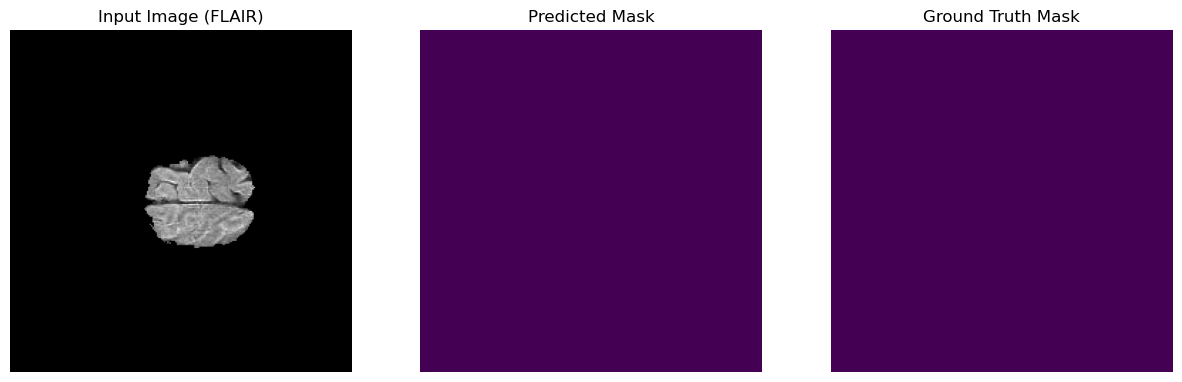

Visualizing sample at index 127 (Dice Score: 1.0000)
Index: 127, Ground Truth Sum: 0, Prediction Sum: 0


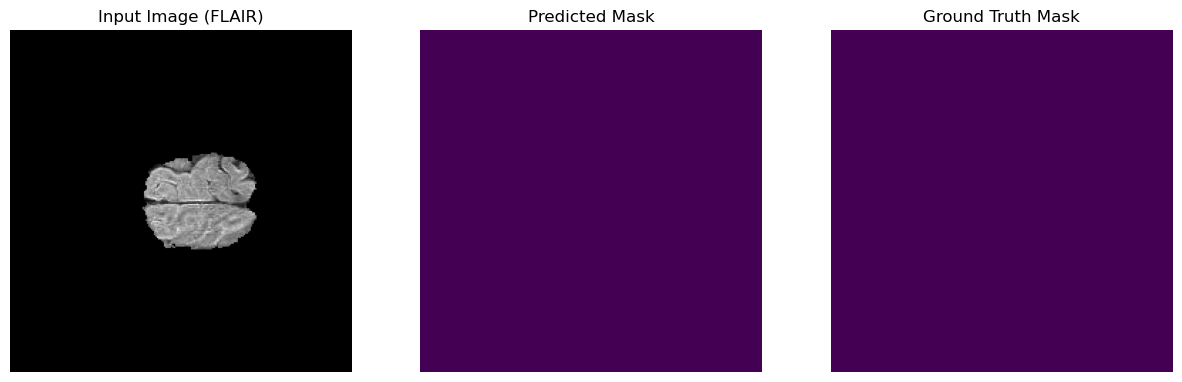

Visualizing sample at index 126 (Dice Score: 1.0000)
Index: 126, Ground Truth Sum: 0, Prediction Sum: 0


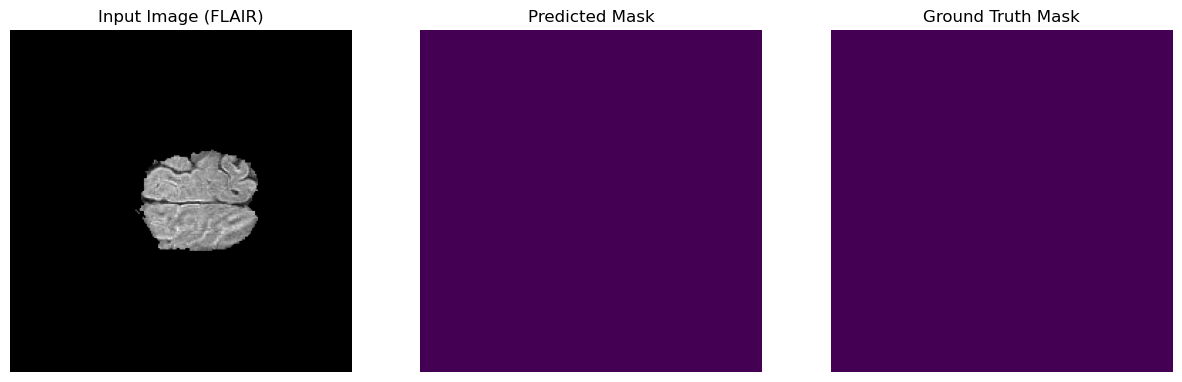

Visualizing sample at index 125 (Dice Score: 1.0000)
Index: 125, Ground Truth Sum: 0, Prediction Sum: 0


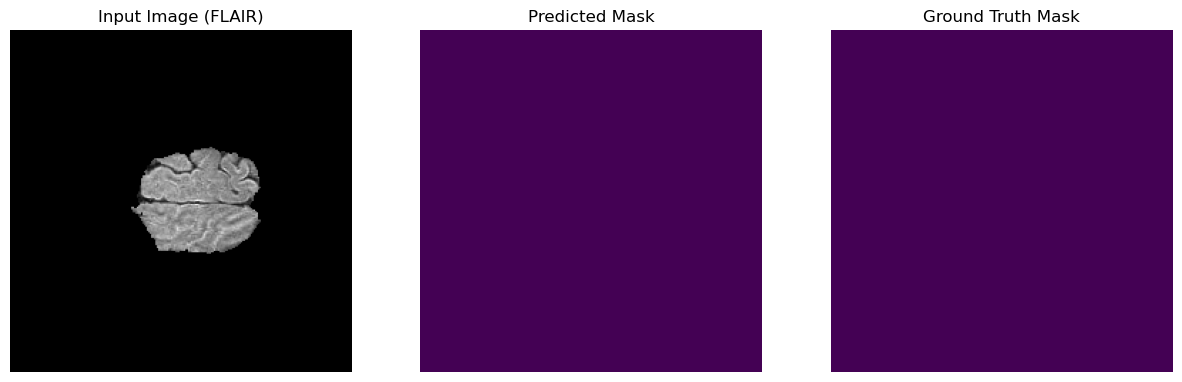

Visualizing sample at index 124 (Dice Score: 1.0000)
Index: 124, Ground Truth Sum: 0, Prediction Sum: 0


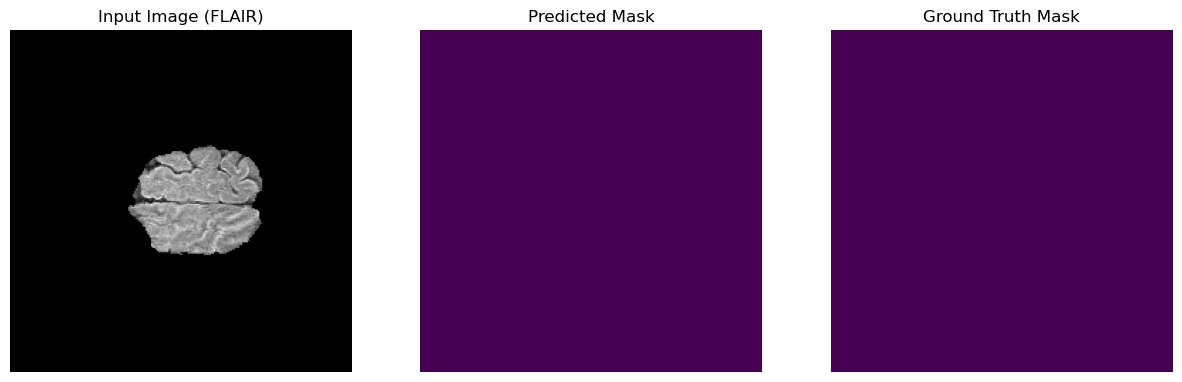

Visualizing sample at index 123 (Dice Score: 1.0000)
Index: 123, Ground Truth Sum: 0, Prediction Sum: 0


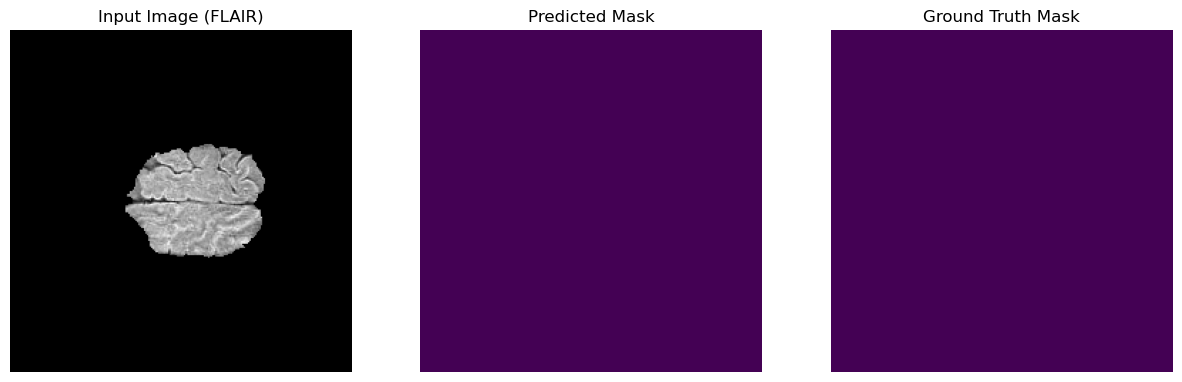

Visualizing sample at index 122 (Dice Score: 1.0000)
Index: 122, Ground Truth Sum: 0, Prediction Sum: 0


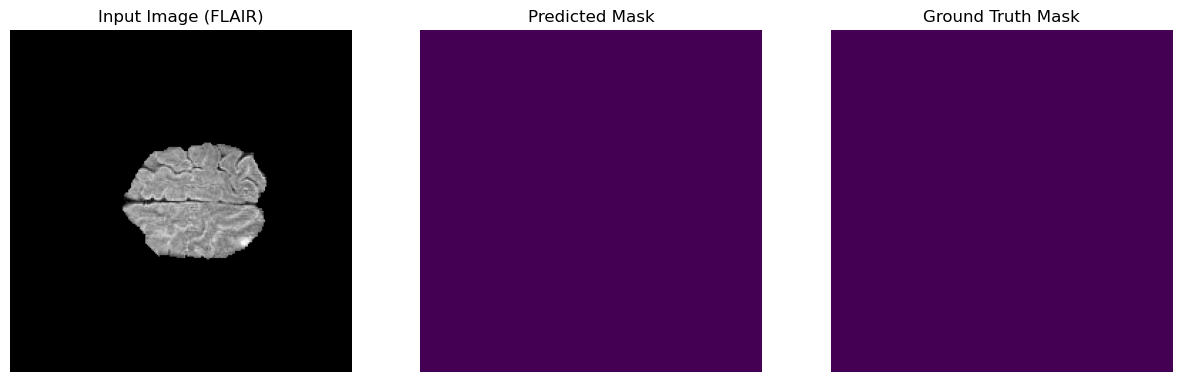

Visualizing sample at index 135 (Dice Score: 1.0000)
Index: 135, Ground Truth Sum: 0, Prediction Sum: 0


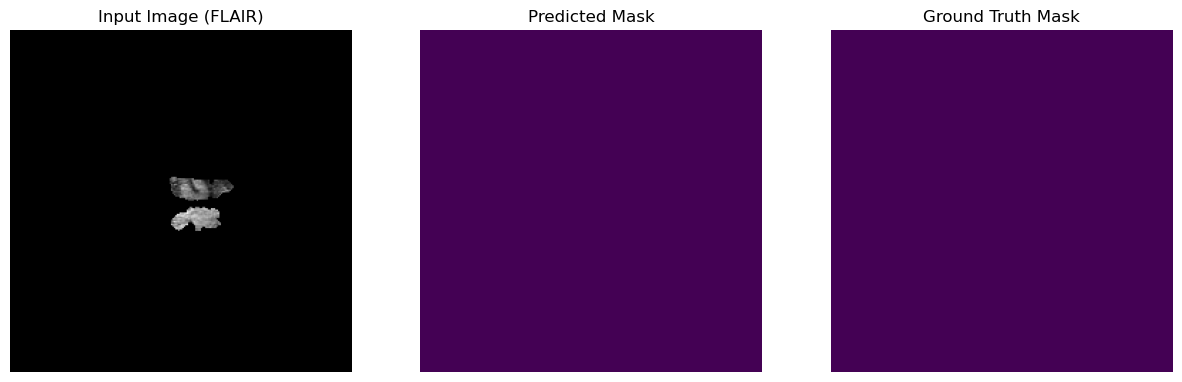

Visualizing sample at index 136 (Dice Score: 1.0000)
Index: 136, Ground Truth Sum: 0, Prediction Sum: 0


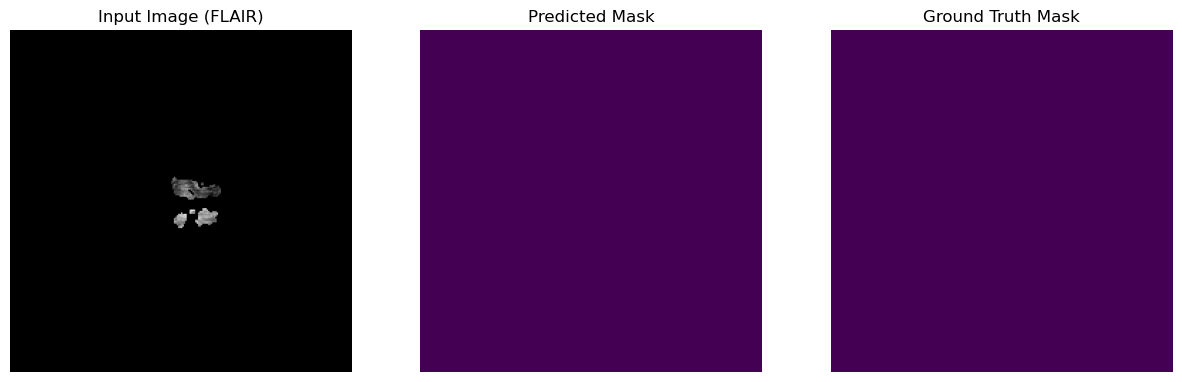

Visualizing sample at index 137 (Dice Score: 1.0000)
Index: 137, Ground Truth Sum: 0, Prediction Sum: 0


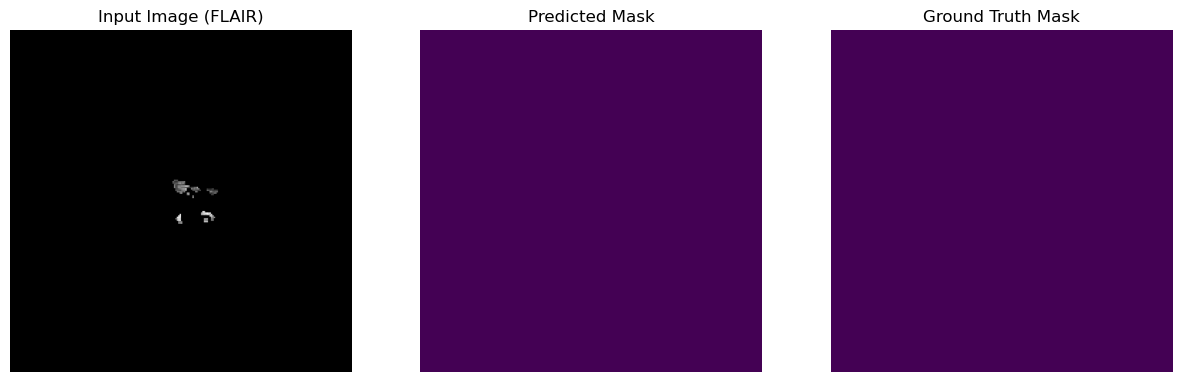

Visualizing sample at index 138 (Dice Score: 1.0000)
Index: 138, Ground Truth Sum: 0, Prediction Sum: 0


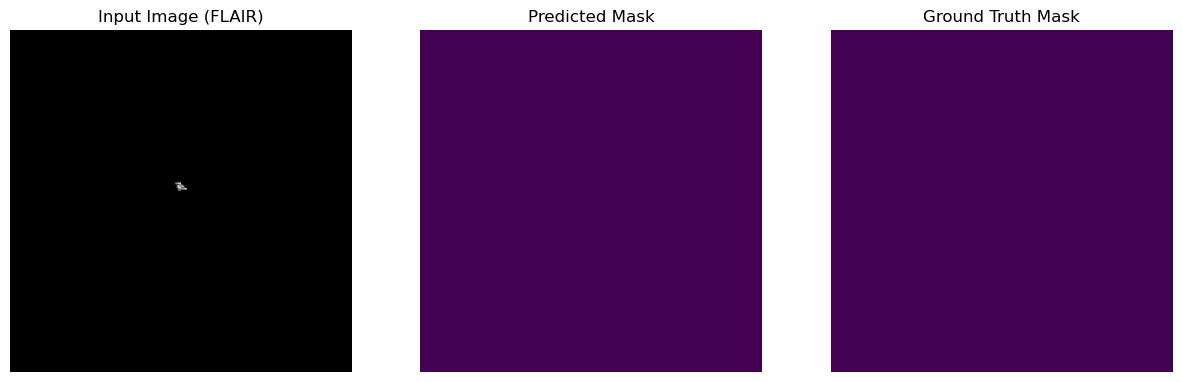

Visualizing sample at index 139 (Dice Score: 1.0000)
Index: 139, Ground Truth Sum: 0, Prediction Sum: 0


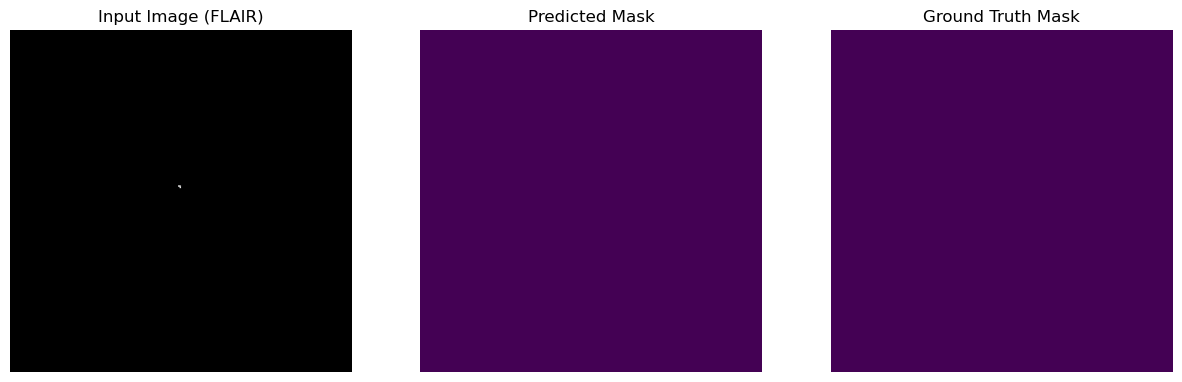

Visualizing sample at index 140 (Dice Score: 1.0000)
Index: 140, Ground Truth Sum: 0, Prediction Sum: 0


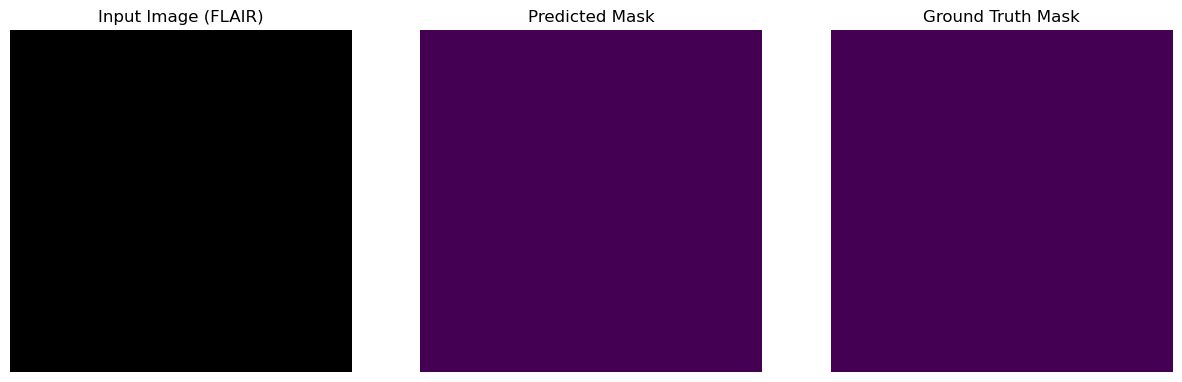

Visualizing sample at index 141 (Dice Score: 1.0000)
Index: 141, Ground Truth Sum: 0, Prediction Sum: 0


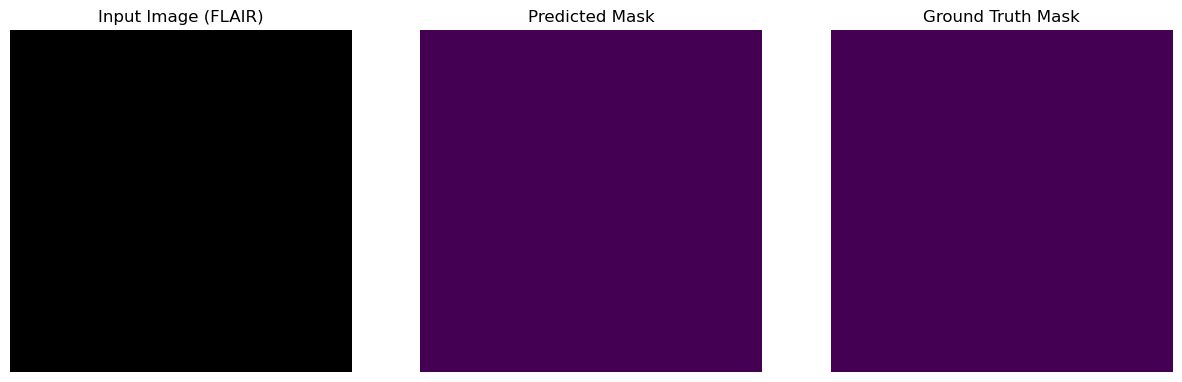

Visualizing sample at index 142 (Dice Score: 1.0000)
Index: 142, Ground Truth Sum: 0, Prediction Sum: 0


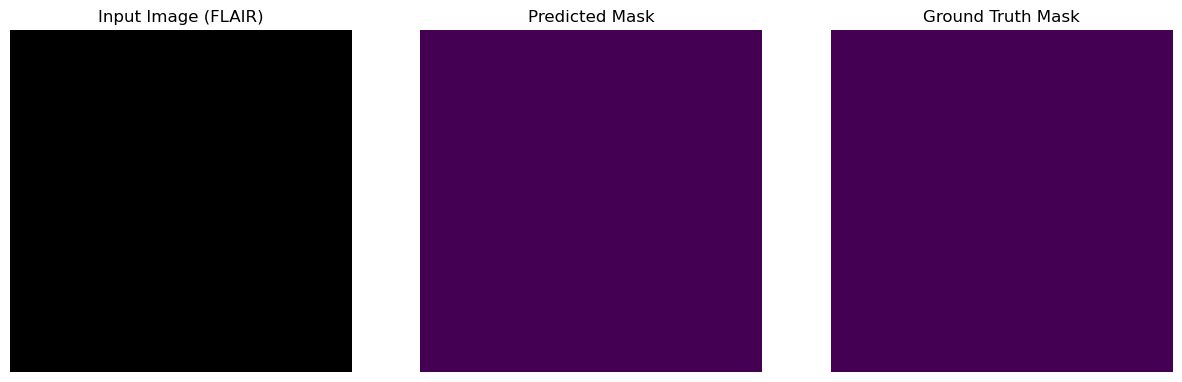

Visualizing sample at index 131 (Dice Score: 1.0000)
Index: 131, Ground Truth Sum: 0, Prediction Sum: 0


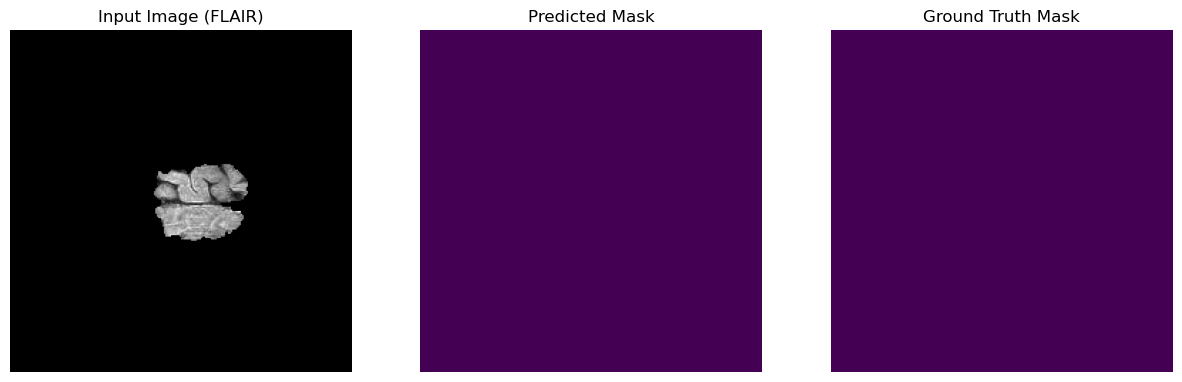

Visualizing sample at index 144 (Dice Score: 1.0000)
Index: 144, Ground Truth Sum: 0, Prediction Sum: 0


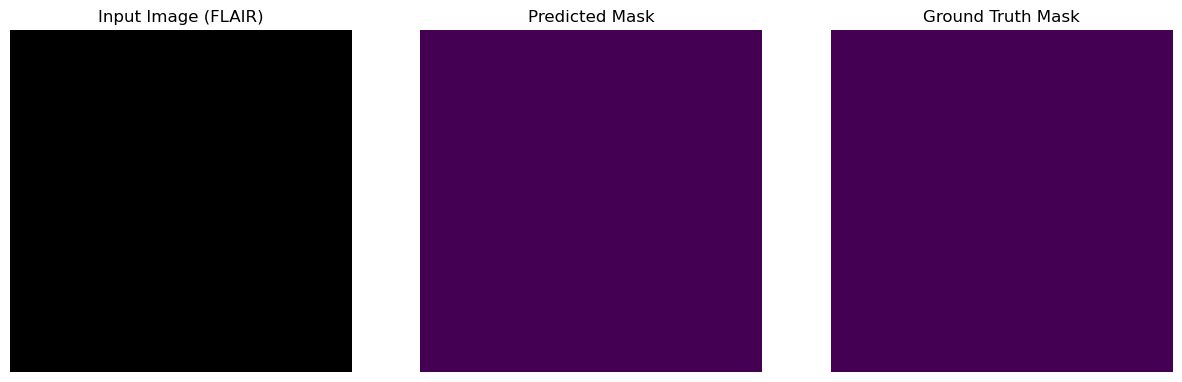

Visualizing sample at index 145 (Dice Score: 1.0000)
Index: 145, Ground Truth Sum: 0, Prediction Sum: 0


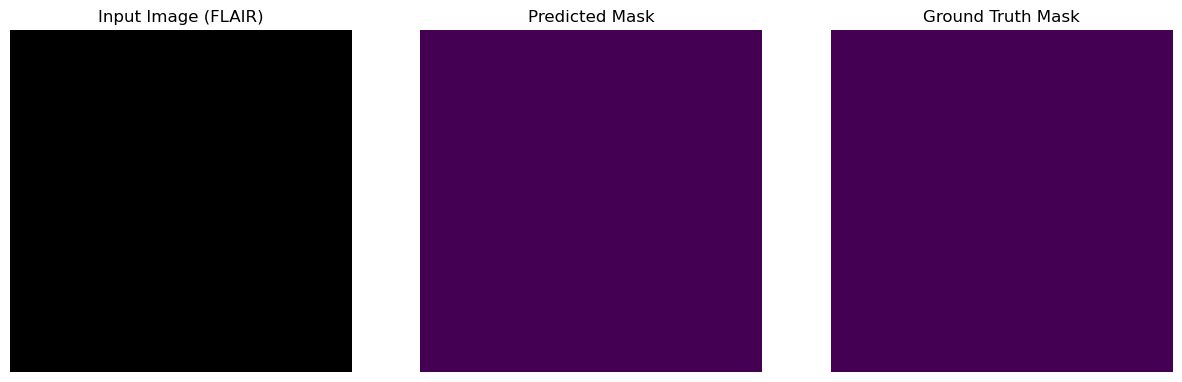

Visualizing sample at index 146 (Dice Score: 1.0000)
Index: 146, Ground Truth Sum: 0, Prediction Sum: 0


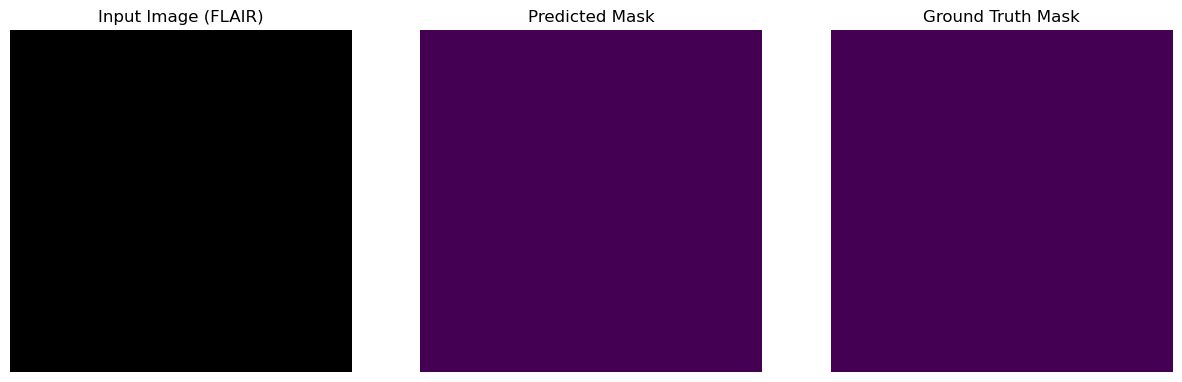

Visualizing sample at index 147 (Dice Score: 1.0000)
Index: 147, Ground Truth Sum: 0, Prediction Sum: 0


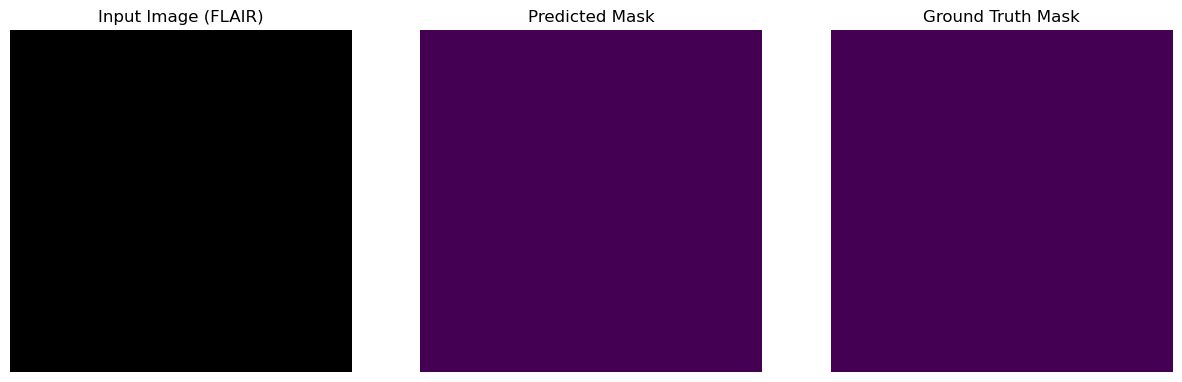

Visualizing sample at index 148 (Dice Score: 1.0000)
Index: 148, Ground Truth Sum: 0, Prediction Sum: 0


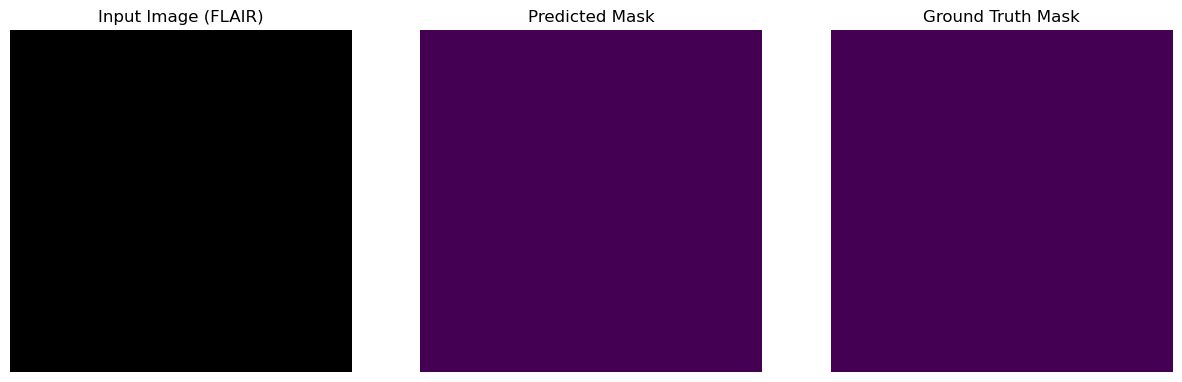

Visualizing sample at index 150 (Dice Score: 1.0000)
Index: 150, Ground Truth Sum: 0, Prediction Sum: 0


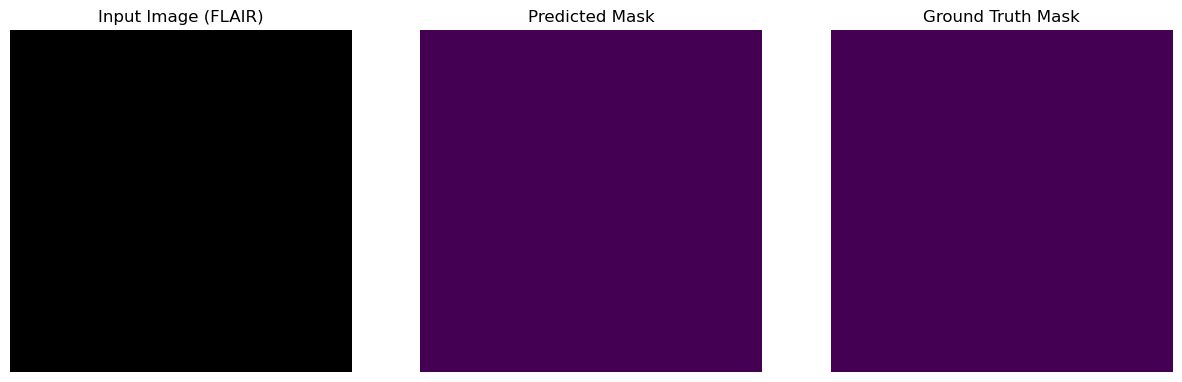

Visualizing sample at index 143 (Dice Score: 1.0000)
Index: 143, Ground Truth Sum: 0, Prediction Sum: 0


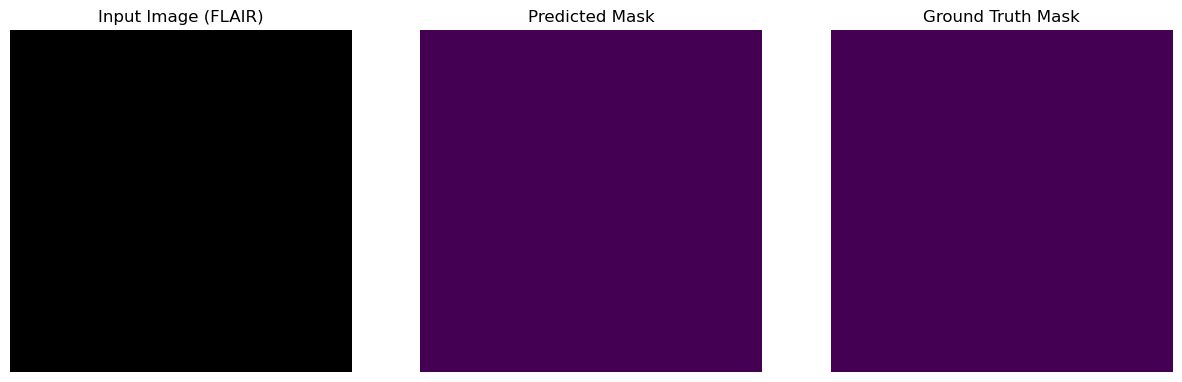

Visualizing sample at index 0 (Dice Score: 1.0000)
Index: 0, Ground Truth Sum: 0, Prediction Sum: 0


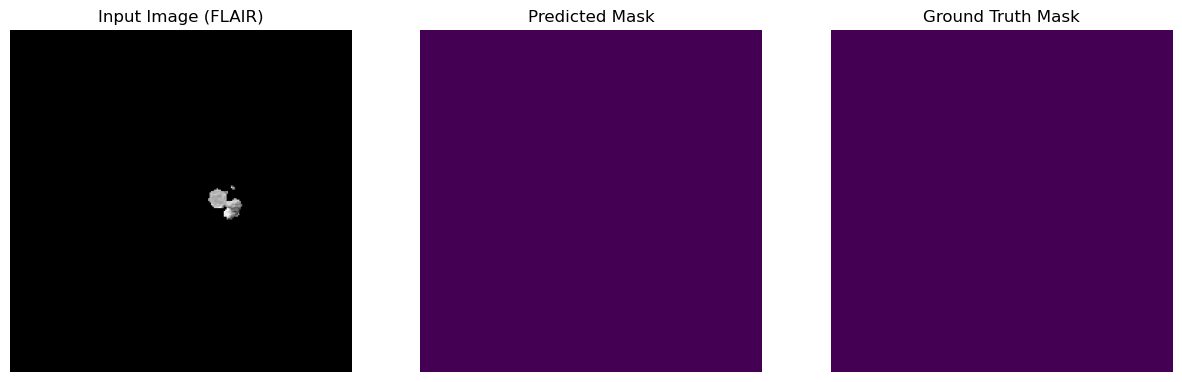

Visualizing sample at index 53 (Dice Score: 1.0000)
Index: 53, Ground Truth Sum: 0, Prediction Sum: 0


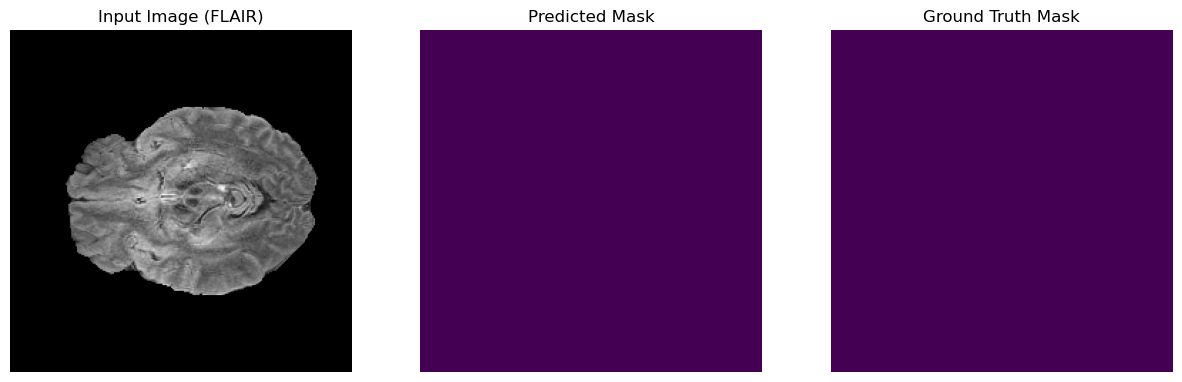

Visualizing sample at index 20 (Dice Score: 1.0000)
Index: 20, Ground Truth Sum: 0, Prediction Sum: 0


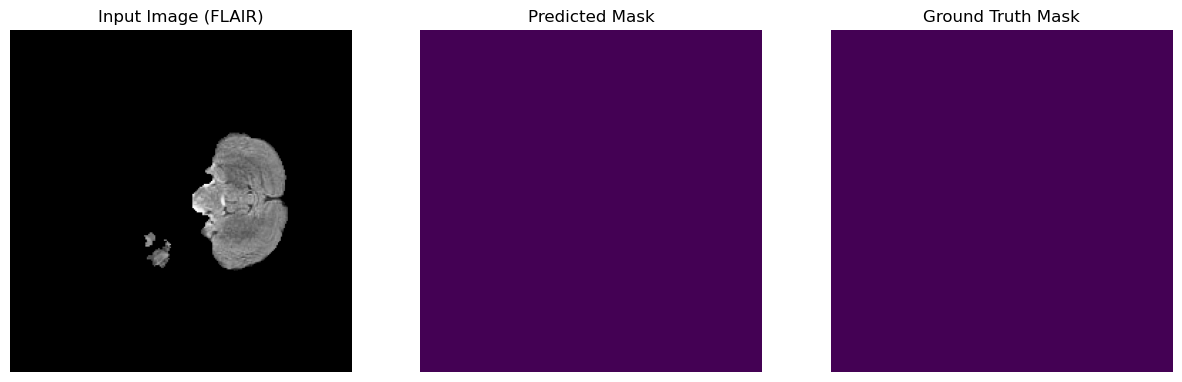

Visualizing sample at index 19 (Dice Score: 1.0000)
Index: 19, Ground Truth Sum: 0, Prediction Sum: 0


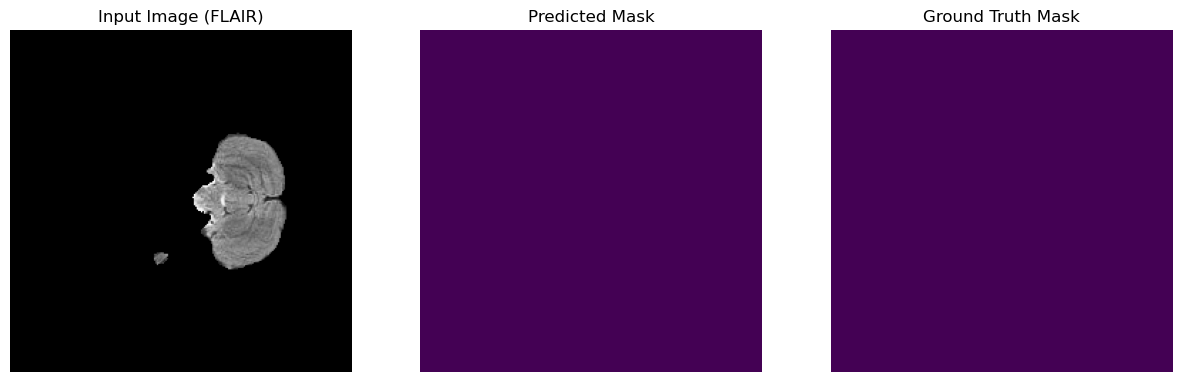

Visualizing sample at index 18 (Dice Score: 1.0000)
Index: 18, Ground Truth Sum: 0, Prediction Sum: 0


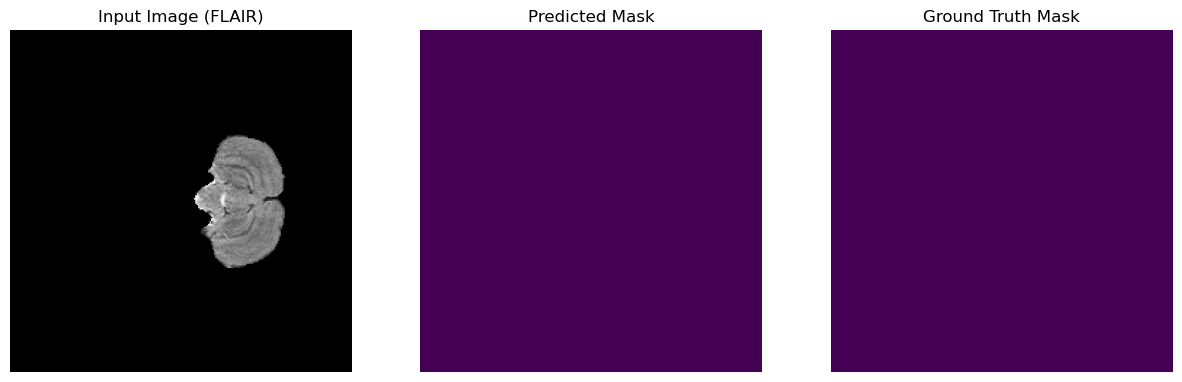

Visualizing sample at index 17 (Dice Score: 1.0000)
Index: 17, Ground Truth Sum: 0, Prediction Sum: 0


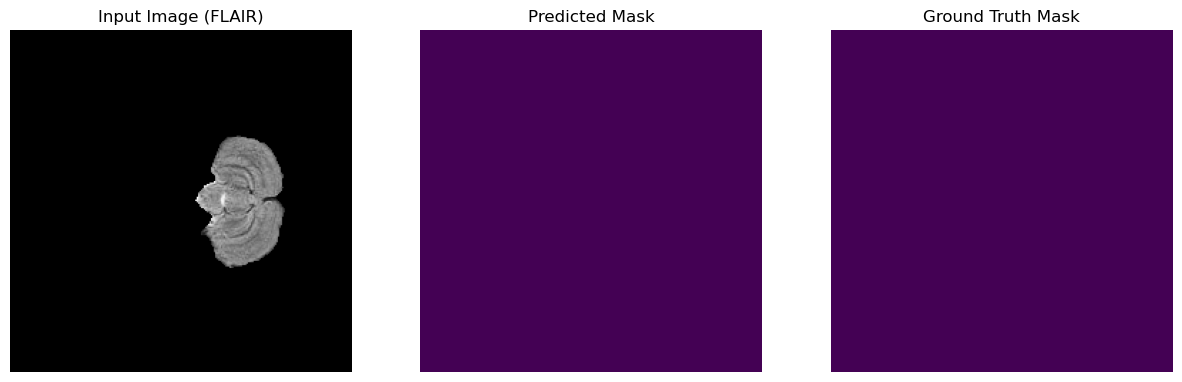

Visualizing sample at index 16 (Dice Score: 1.0000)
Index: 16, Ground Truth Sum: 0, Prediction Sum: 0


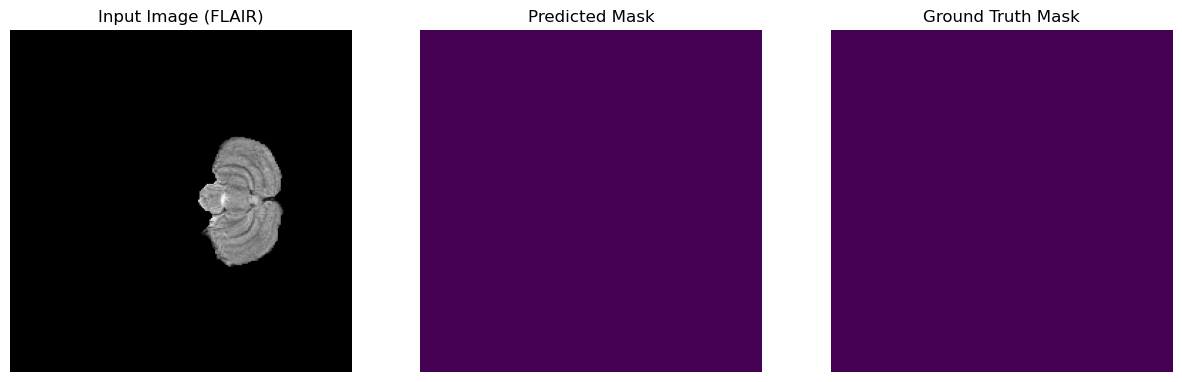

Visualizing sample at index 15 (Dice Score: 1.0000)
Index: 15, Ground Truth Sum: 0, Prediction Sum: 0


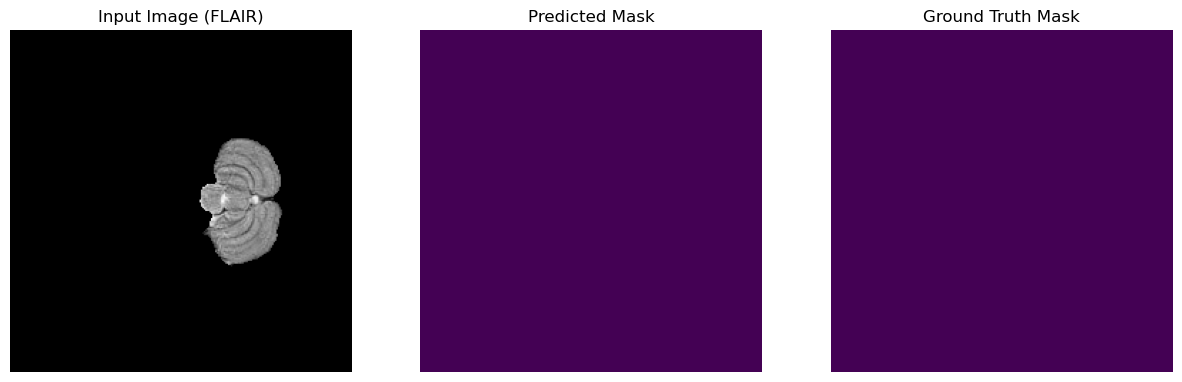

Visualizing sample at index 14 (Dice Score: 1.0000)
Index: 14, Ground Truth Sum: 0, Prediction Sum: 0


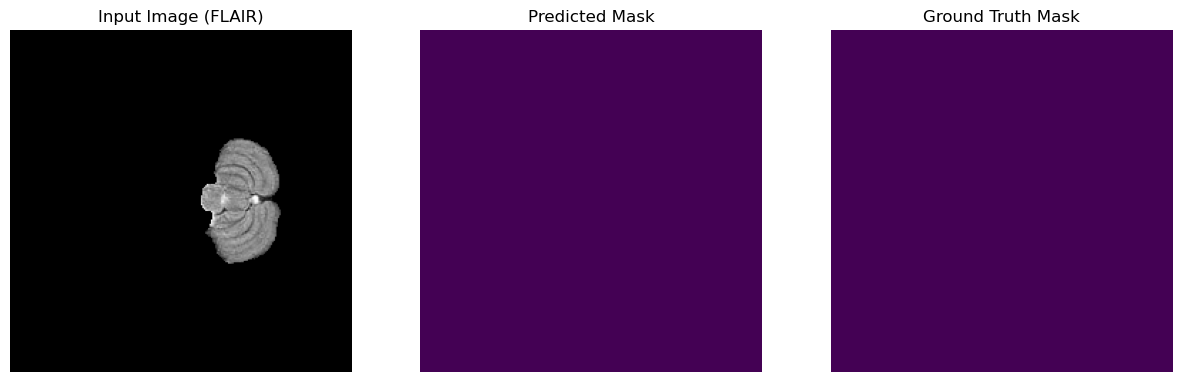

Visualizing sample at index 13 (Dice Score: 1.0000)
Index: 13, Ground Truth Sum: 0, Prediction Sum: 0


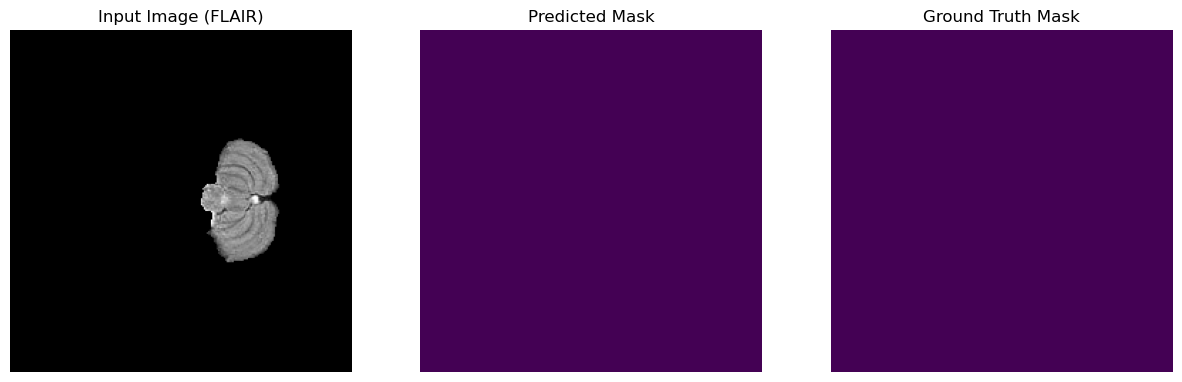

Visualizing sample at index 12 (Dice Score: 1.0000)
Index: 12, Ground Truth Sum: 0, Prediction Sum: 0


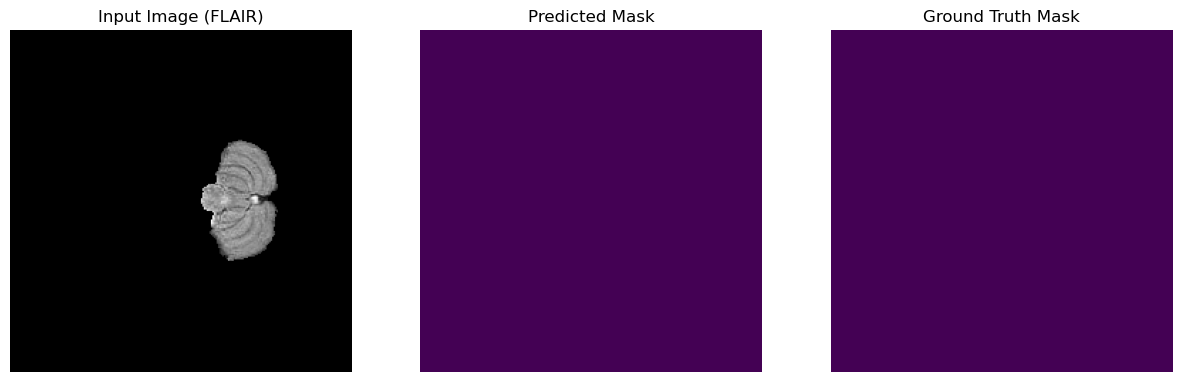

Visualizing sample at index 21 (Dice Score: 1.0000)
Index: 21, Ground Truth Sum: 0, Prediction Sum: 0


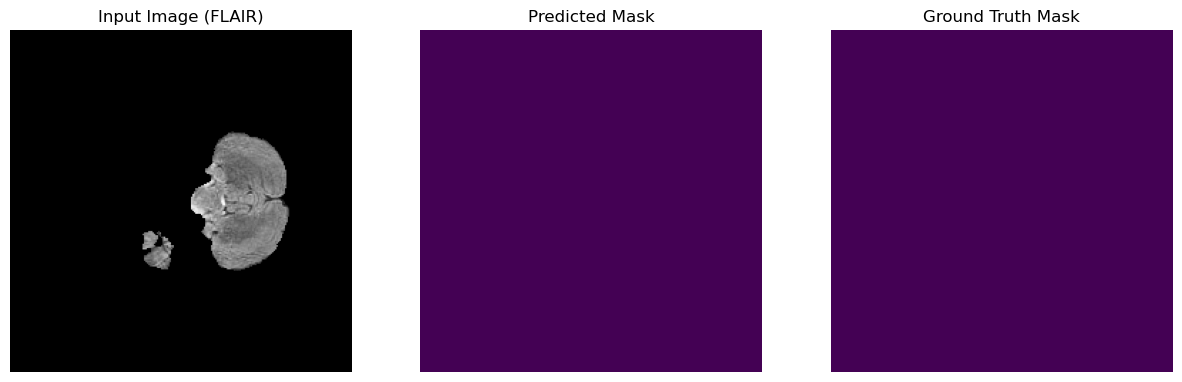

Visualizing sample at index 11 (Dice Score: 1.0000)
Index: 11, Ground Truth Sum: 0, Prediction Sum: 0


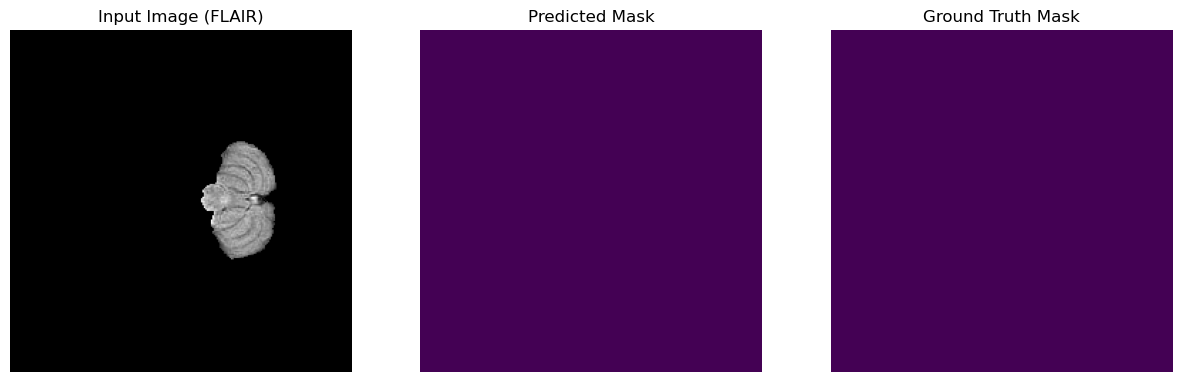

Visualizing sample at index 9 (Dice Score: 1.0000)
Index: 9, Ground Truth Sum: 0, Prediction Sum: 0


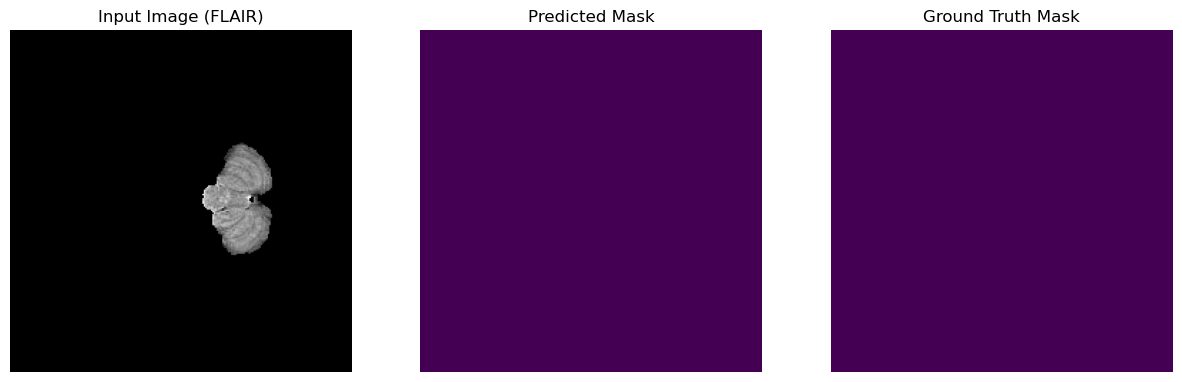

Visualizing sample at index 8 (Dice Score: 1.0000)
Index: 8, Ground Truth Sum: 0, Prediction Sum: 0


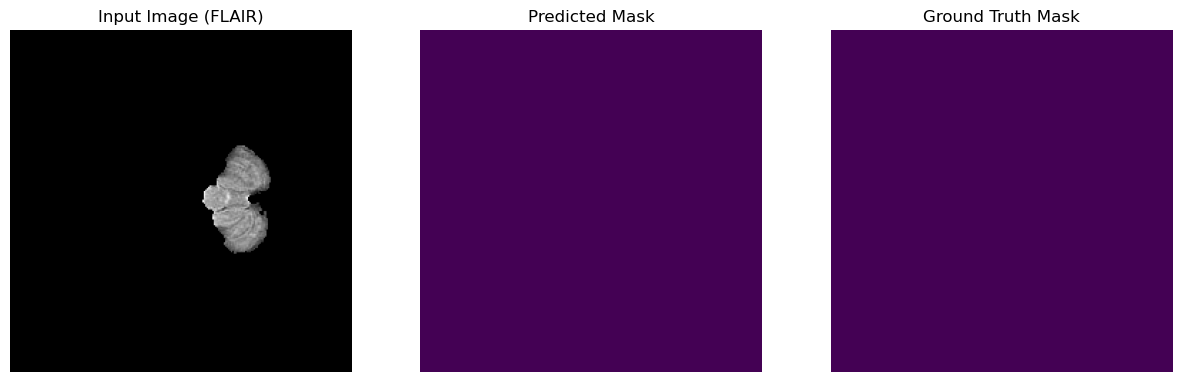

Visualizing sample at index 7 (Dice Score: 1.0000)
Index: 7, Ground Truth Sum: 0, Prediction Sum: 0


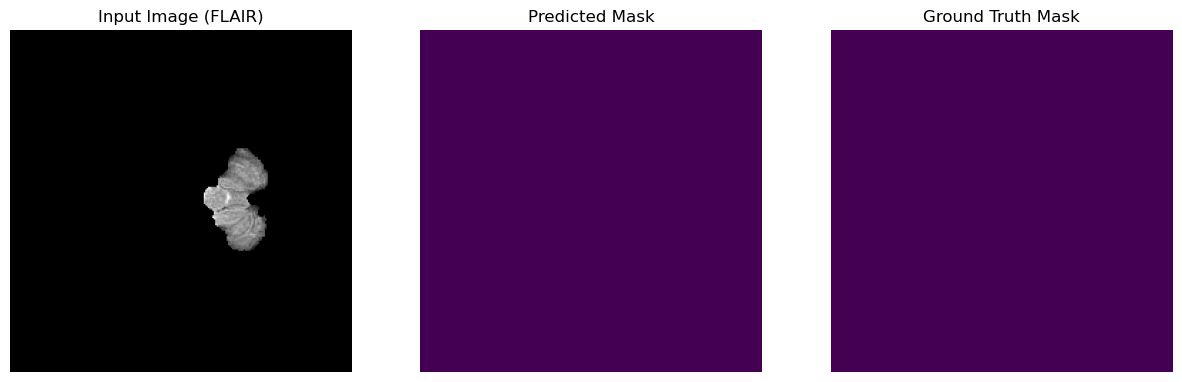

Visualizing sample at index 6 (Dice Score: 1.0000)
Index: 6, Ground Truth Sum: 0, Prediction Sum: 0


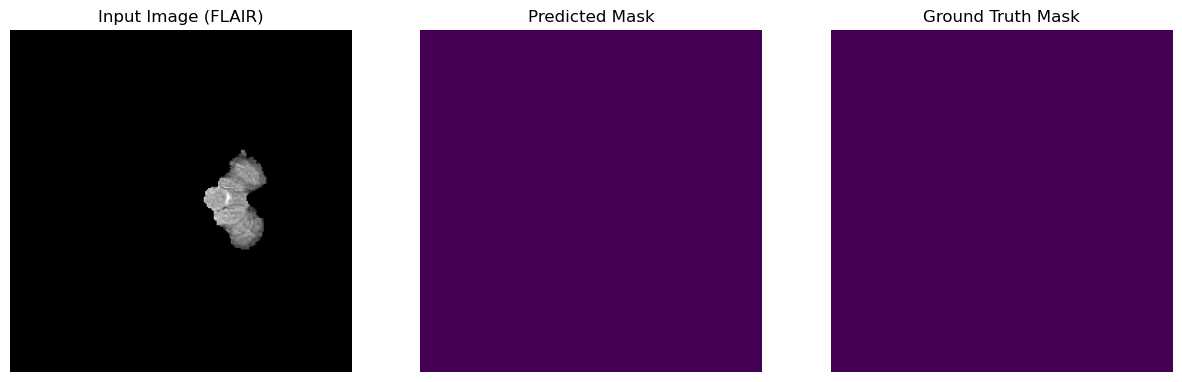

Visualizing sample at index 5 (Dice Score: 1.0000)
Index: 5, Ground Truth Sum: 0, Prediction Sum: 0


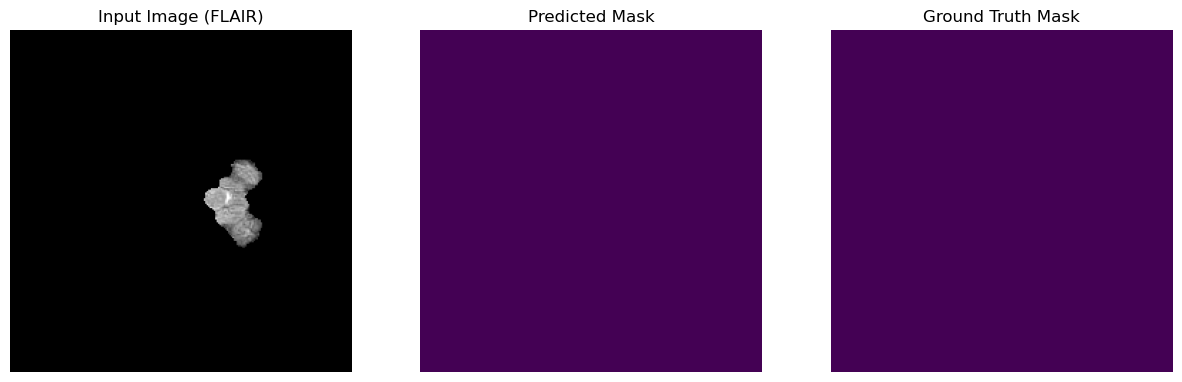

Visualizing sample at index 4 (Dice Score: 1.0000)
Index: 4, Ground Truth Sum: 0, Prediction Sum: 0


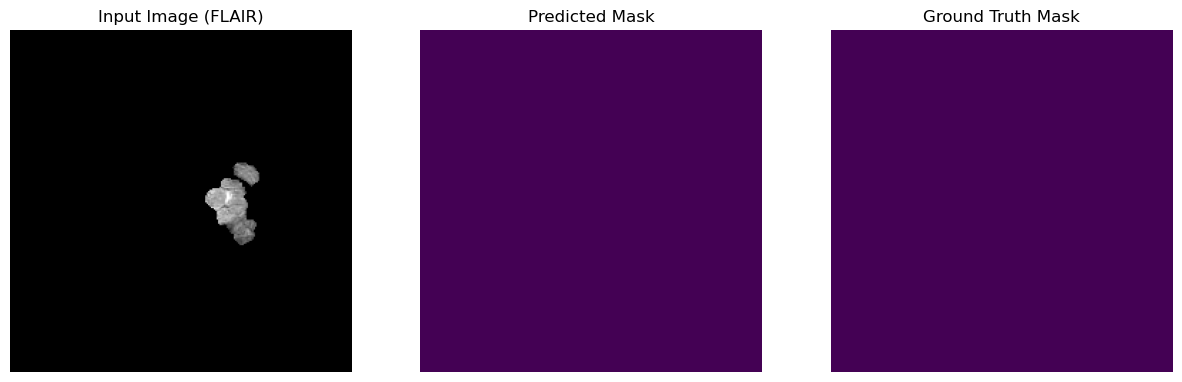

Visualizing sample at index 3 (Dice Score: 1.0000)
Index: 3, Ground Truth Sum: 0, Prediction Sum: 0


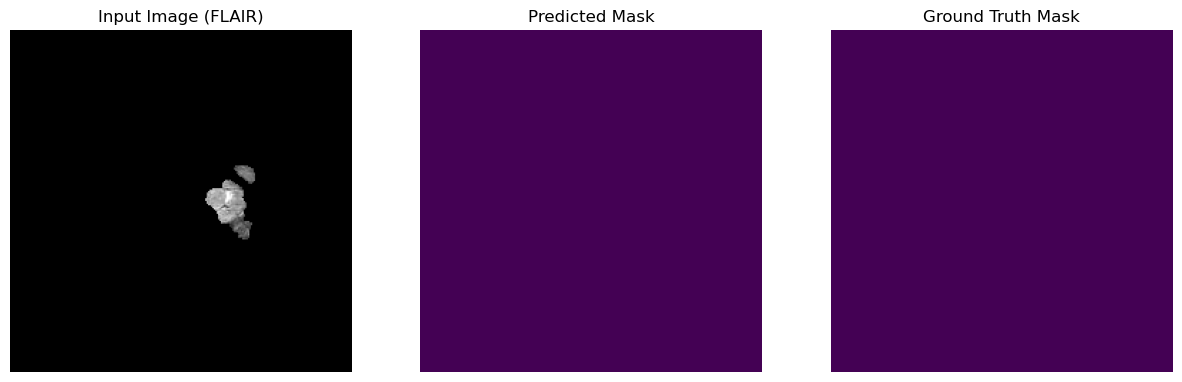

Visualizing sample at index 2 (Dice Score: 1.0000)
Index: 2, Ground Truth Sum: 0, Prediction Sum: 0


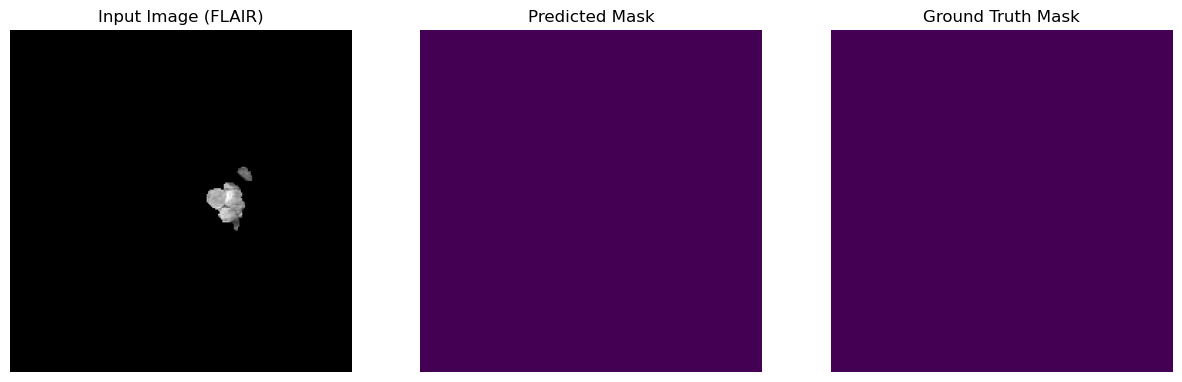

Visualizing sample at index 1 (Dice Score: 1.0000)
Index: 1, Ground Truth Sum: 0, Prediction Sum: 0


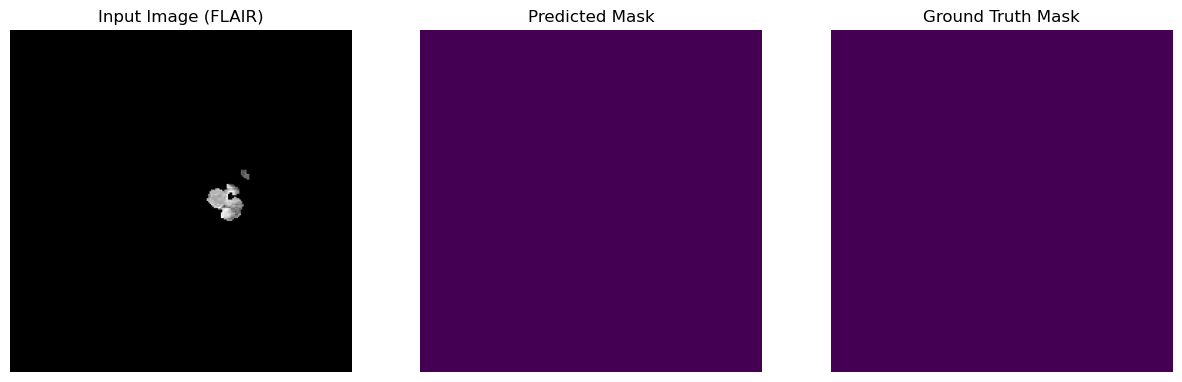

Visualizing sample at index 10 (Dice Score: 1.0000)
Index: 10, Ground Truth Sum: 0, Prediction Sum: 0


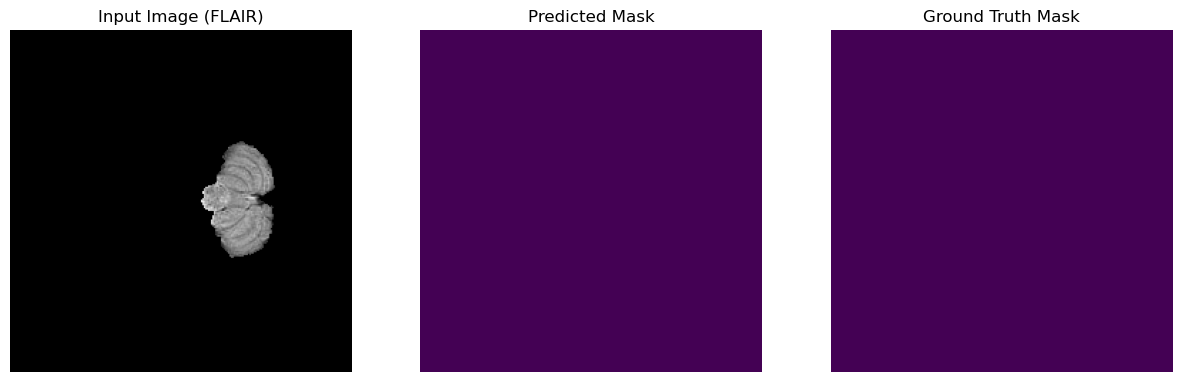

Visualizing sample at index 22 (Dice Score: 1.0000)
Index: 22, Ground Truth Sum: 0, Prediction Sum: 0


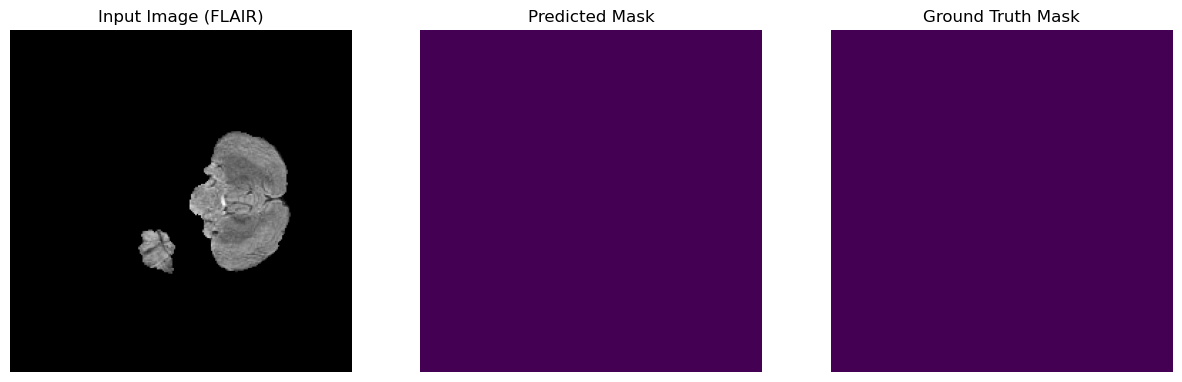

Visualizing sample at index 23 (Dice Score: 1.0000)
Index: 23, Ground Truth Sum: 0, Prediction Sum: 0


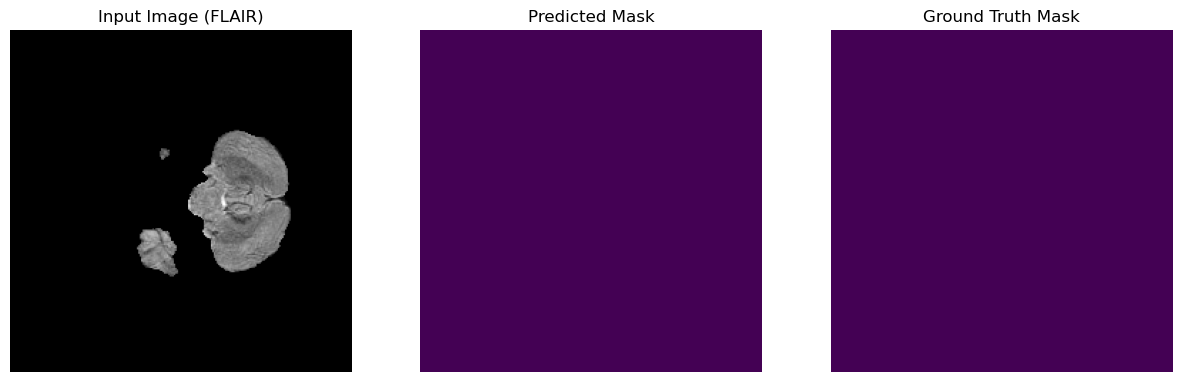

Visualizing sample at index 27 (Dice Score: 1.0000)
Index: 27, Ground Truth Sum: 0, Prediction Sum: 0


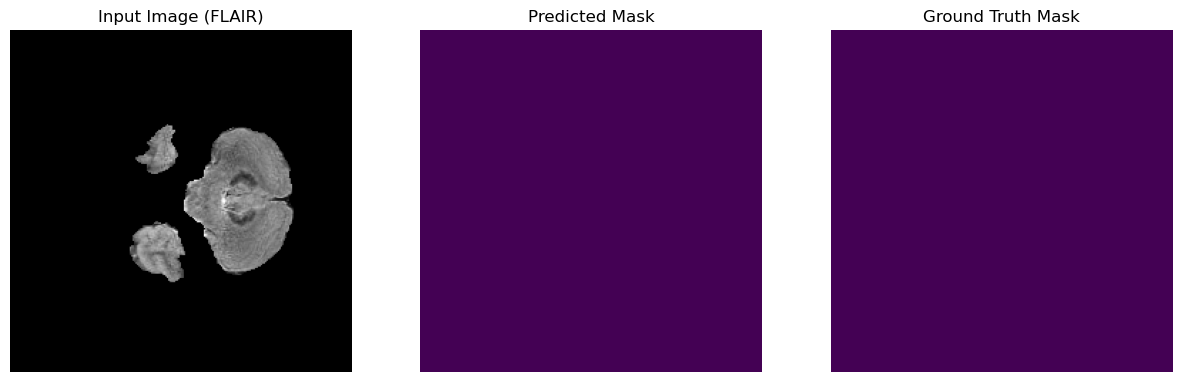

Visualizing sample at index 49 (Dice Score: 1.0000)
Index: 49, Ground Truth Sum: 0, Prediction Sum: 0


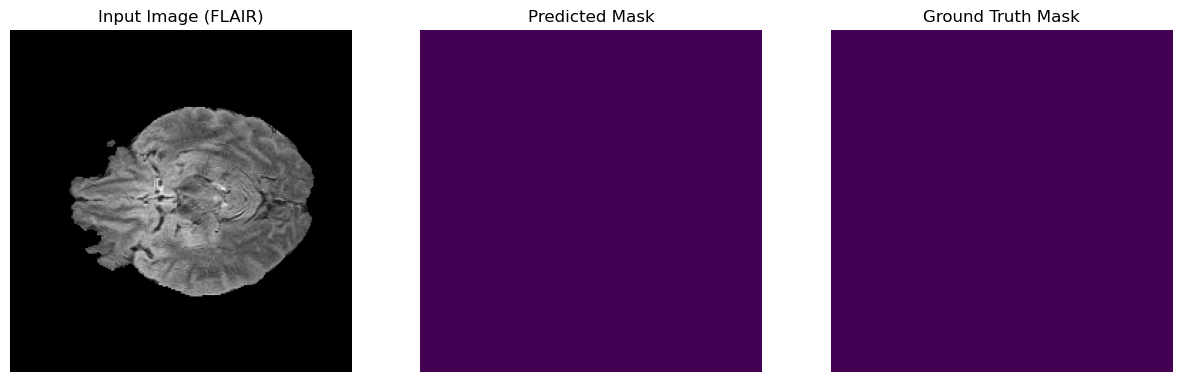

Visualizing sample at index 48 (Dice Score: 1.0000)
Index: 48, Ground Truth Sum: 0, Prediction Sum: 0


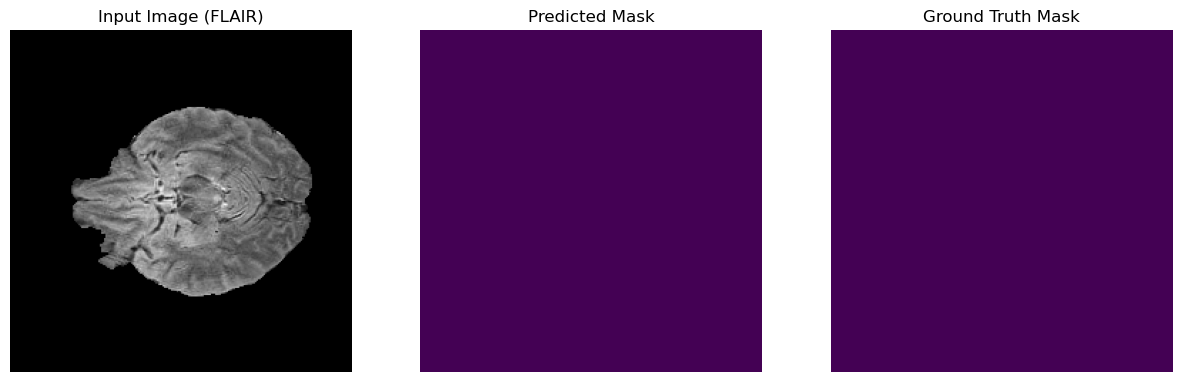

Visualizing sample at index 47 (Dice Score: 1.0000)
Index: 47, Ground Truth Sum: 0, Prediction Sum: 0


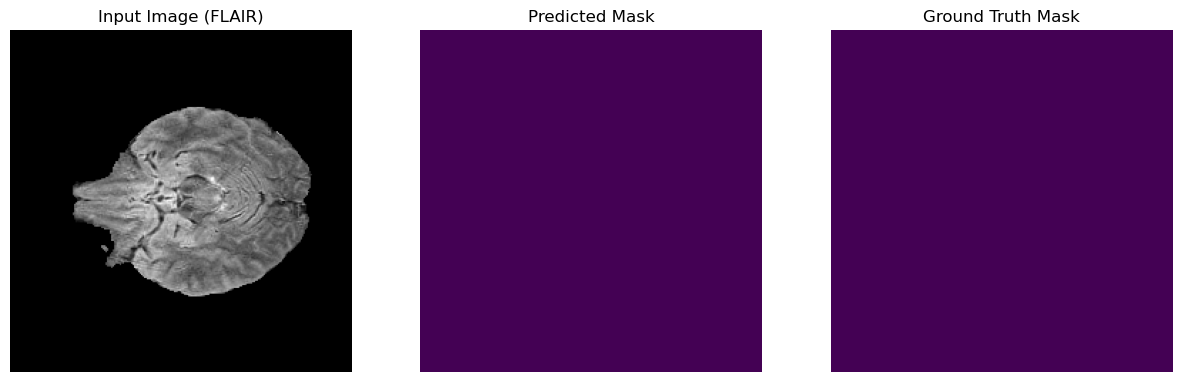

Visualizing sample at index 46 (Dice Score: 1.0000)
Index: 46, Ground Truth Sum: 0, Prediction Sum: 0


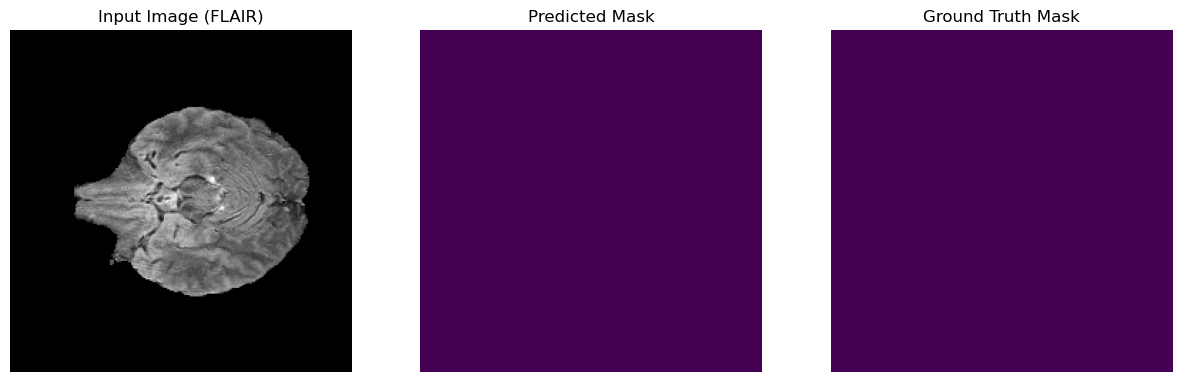

Visualizing sample at index 45 (Dice Score: 1.0000)
Index: 45, Ground Truth Sum: 0, Prediction Sum: 0


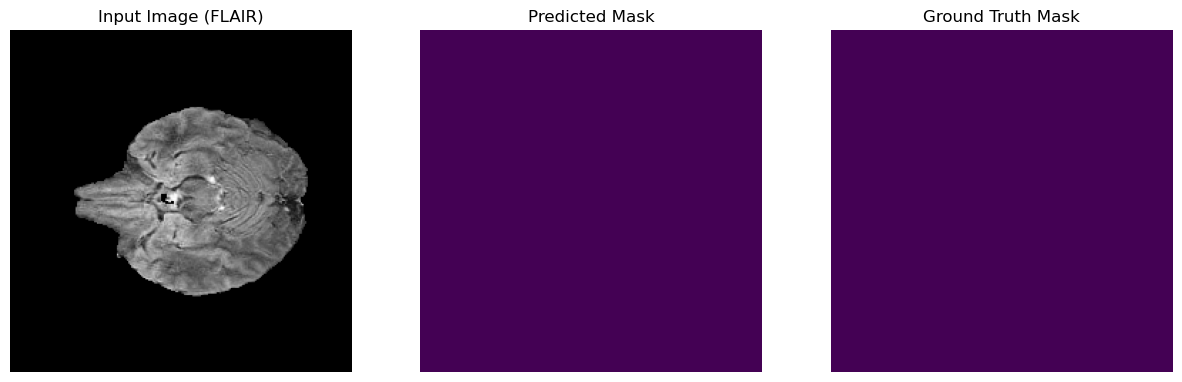

Visualizing sample at index 44 (Dice Score: 1.0000)
Index: 44, Ground Truth Sum: 0, Prediction Sum: 0


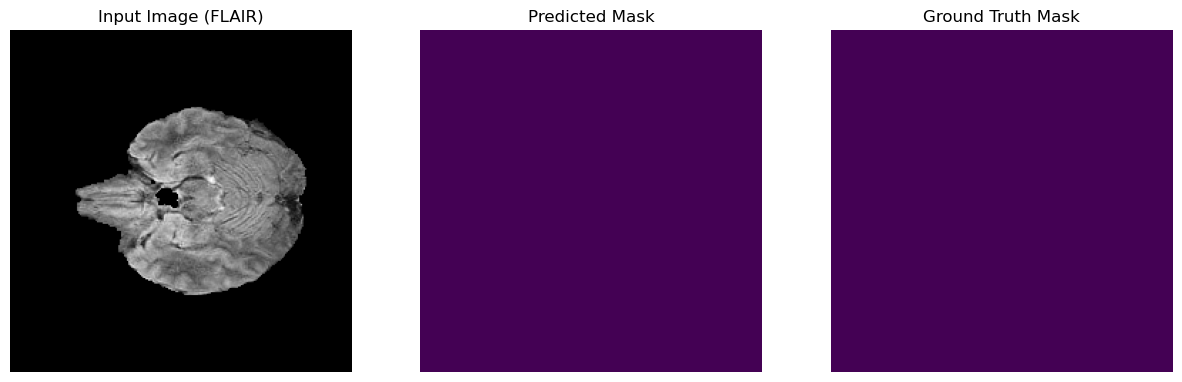

Visualizing sample at index 43 (Dice Score: 1.0000)
Index: 43, Ground Truth Sum: 0, Prediction Sum: 0


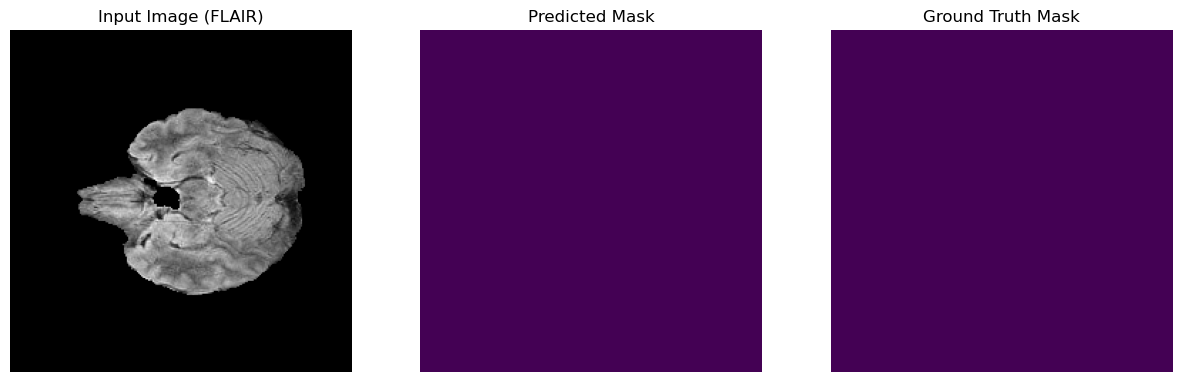

Visualizing sample at index 42 (Dice Score: 1.0000)
Index: 42, Ground Truth Sum: 0, Prediction Sum: 0


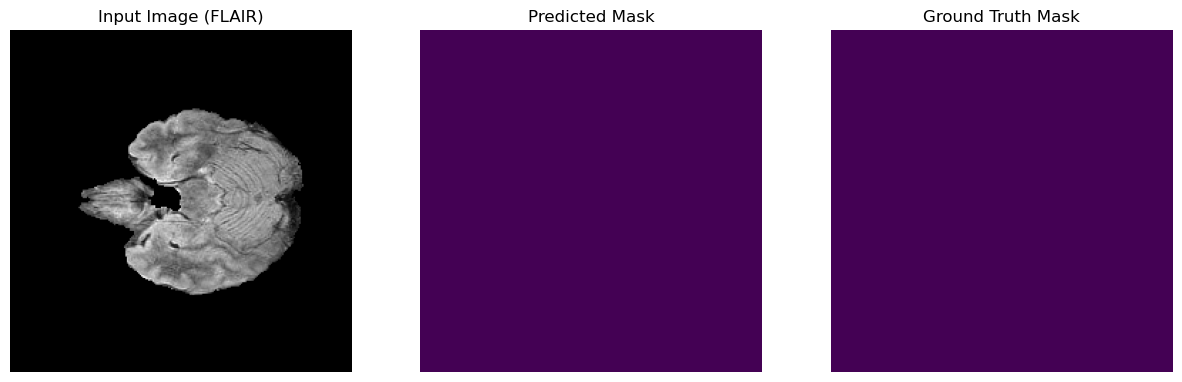

Visualizing sample at index 41 (Dice Score: 1.0000)
Index: 41, Ground Truth Sum: 0, Prediction Sum: 0


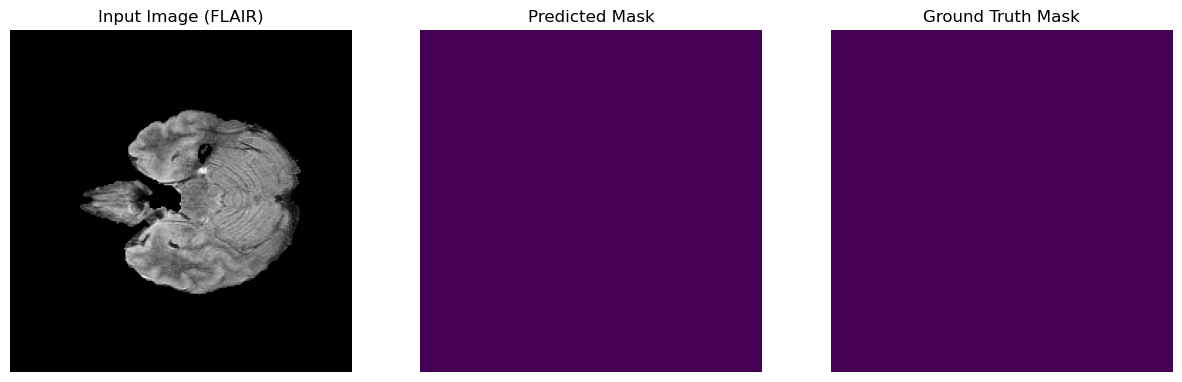

Visualizing sample at index 40 (Dice Score: 1.0000)
Index: 40, Ground Truth Sum: 0, Prediction Sum: 0


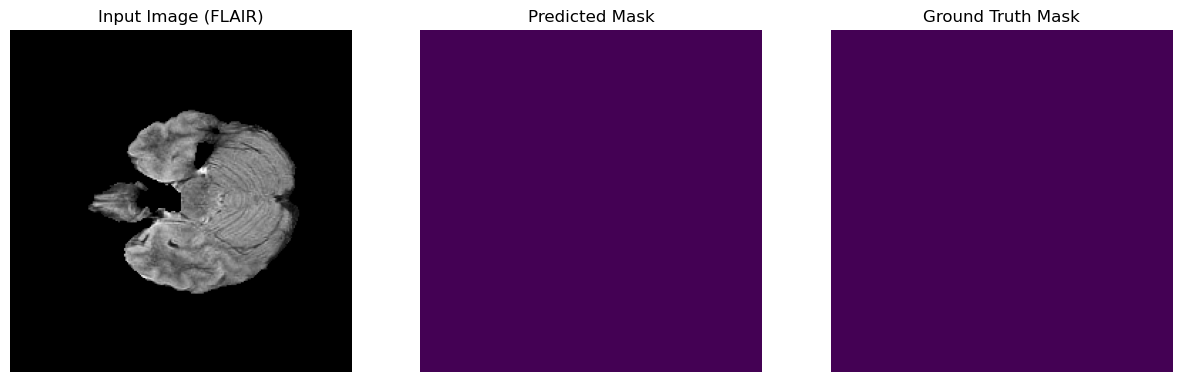

Visualizing sample at index 39 (Dice Score: 1.0000)
Index: 39, Ground Truth Sum: 0, Prediction Sum: 0


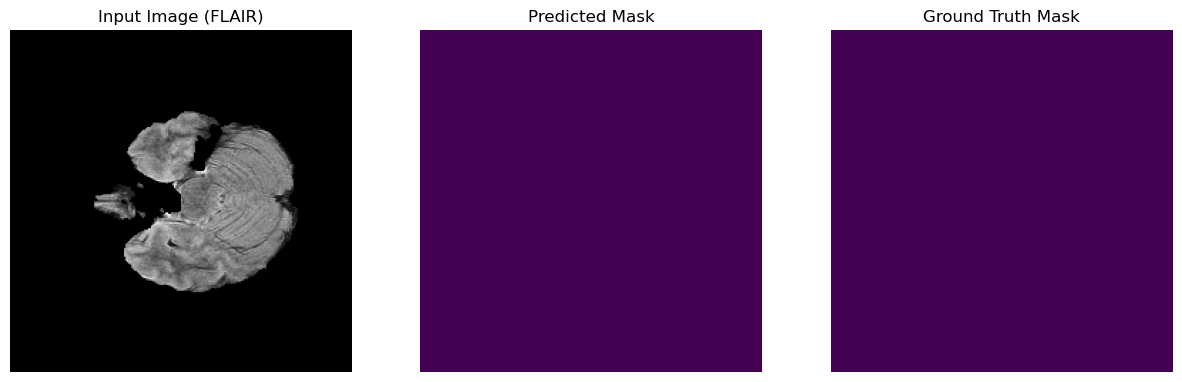

Visualizing sample at index 38 (Dice Score: 1.0000)
Index: 38, Ground Truth Sum: 0, Prediction Sum: 0


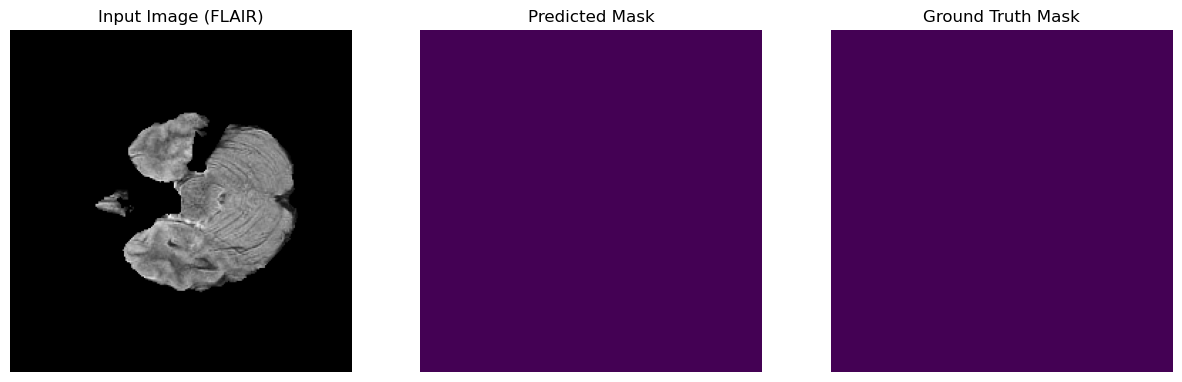

Visualizing sample at index 36 (Dice Score: 1.0000)
Index: 36, Ground Truth Sum: 0, Prediction Sum: 0


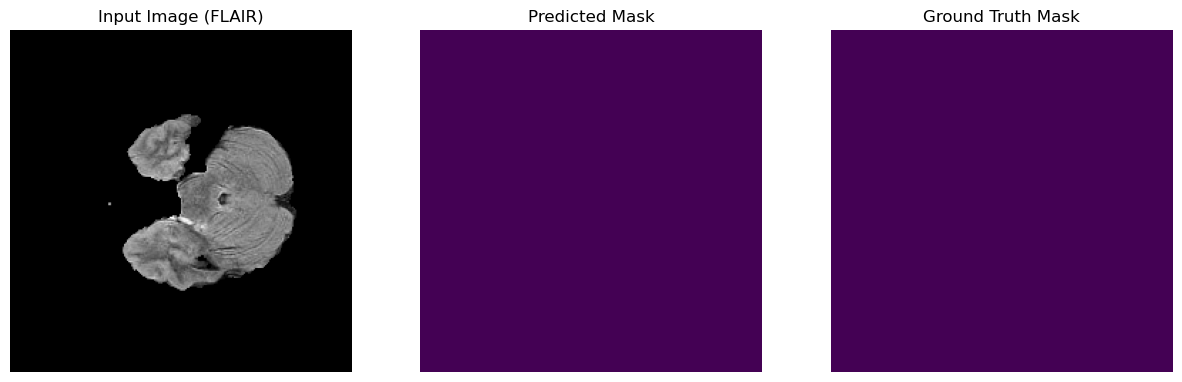

Visualizing sample at index 35 (Dice Score: 1.0000)
Index: 35, Ground Truth Sum: 0, Prediction Sum: 0


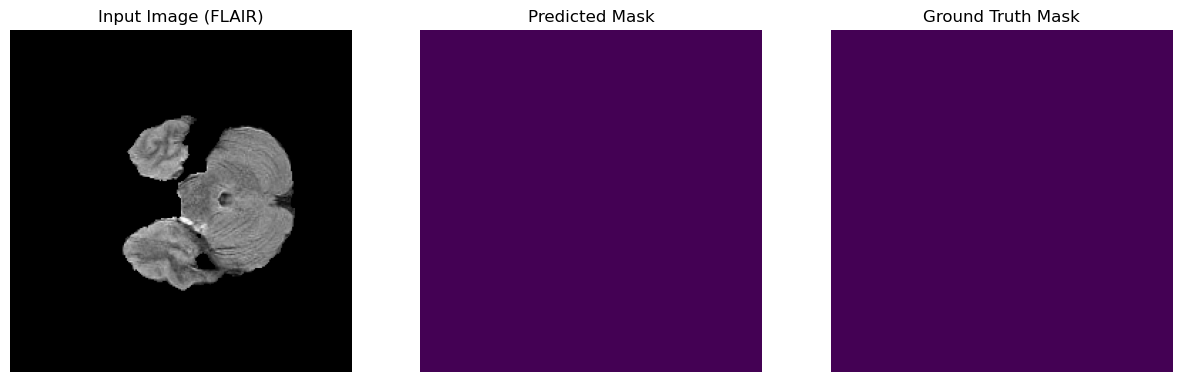

Visualizing sample at index 34 (Dice Score: 1.0000)
Index: 34, Ground Truth Sum: 0, Prediction Sum: 0


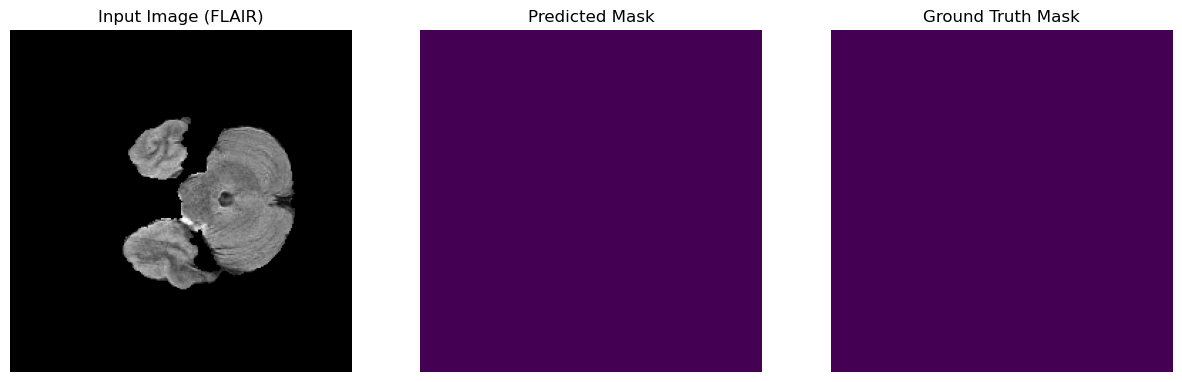

Visualizing sample at index 33 (Dice Score: 1.0000)
Index: 33, Ground Truth Sum: 0, Prediction Sum: 0


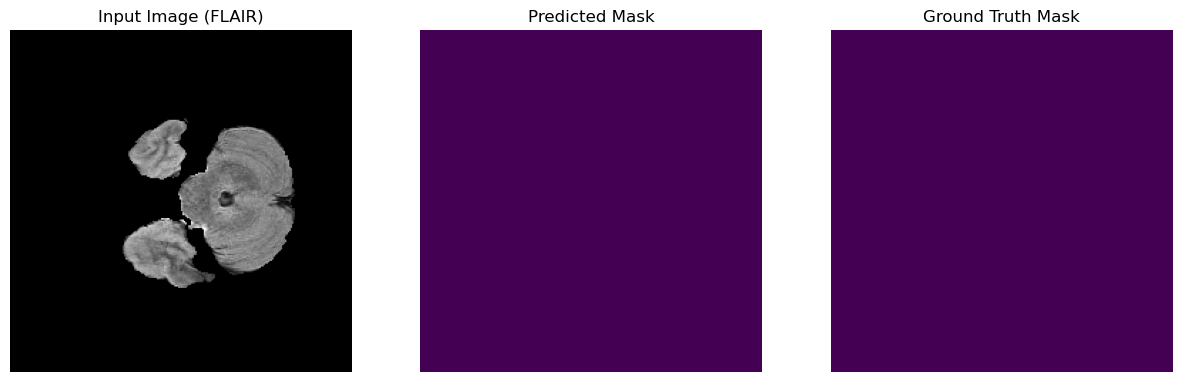

Visualizing sample at index 32 (Dice Score: 1.0000)
Index: 32, Ground Truth Sum: 0, Prediction Sum: 0


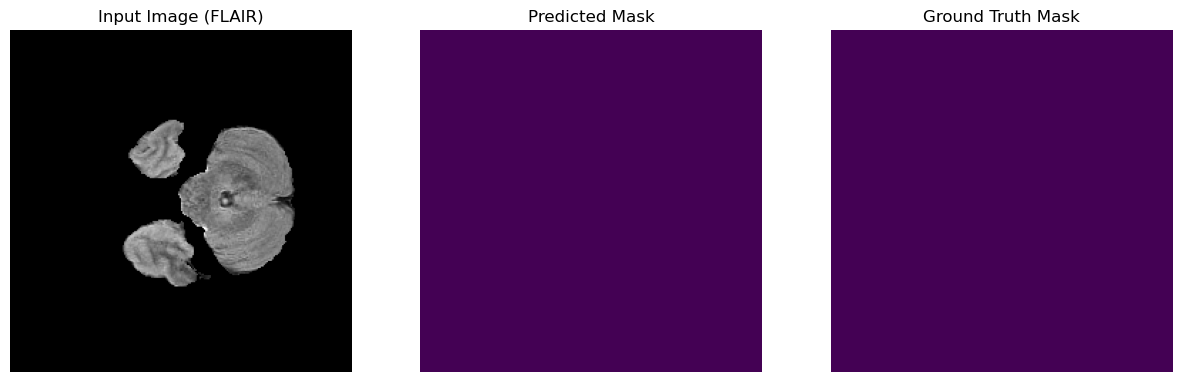

Visualizing sample at index 31 (Dice Score: 1.0000)
Index: 31, Ground Truth Sum: 0, Prediction Sum: 0


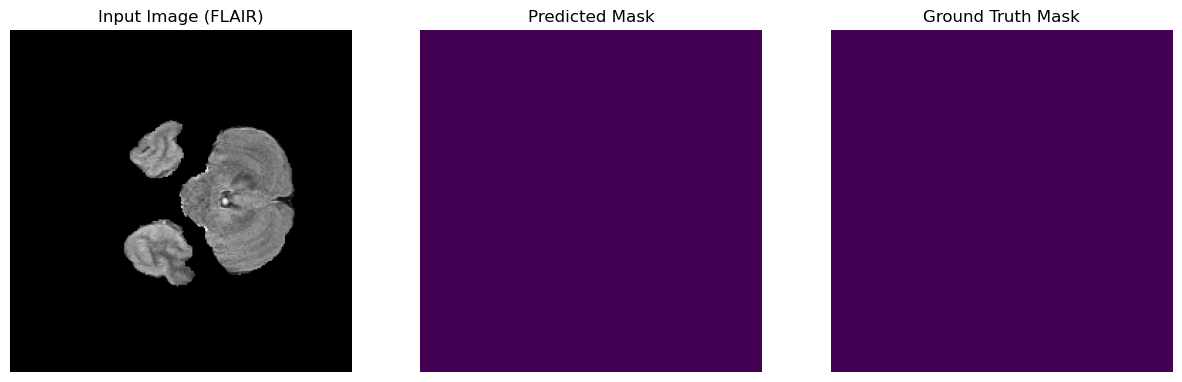

Visualizing sample at index 30 (Dice Score: 1.0000)
Index: 30, Ground Truth Sum: 0, Prediction Sum: 0


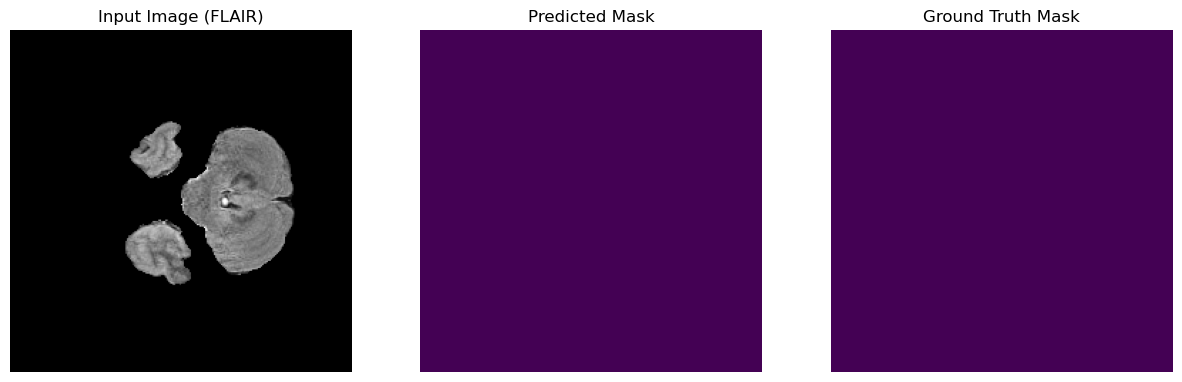

Visualizing sample at index 29 (Dice Score: 1.0000)
Index: 29, Ground Truth Sum: 0, Prediction Sum: 0


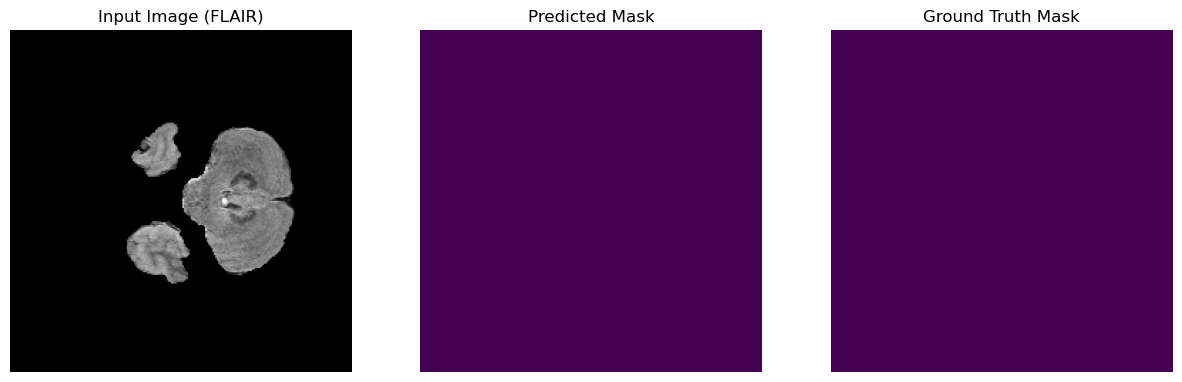

Visualizing sample at index 28 (Dice Score: 1.0000)
Index: 28, Ground Truth Sum: 0, Prediction Sum: 0


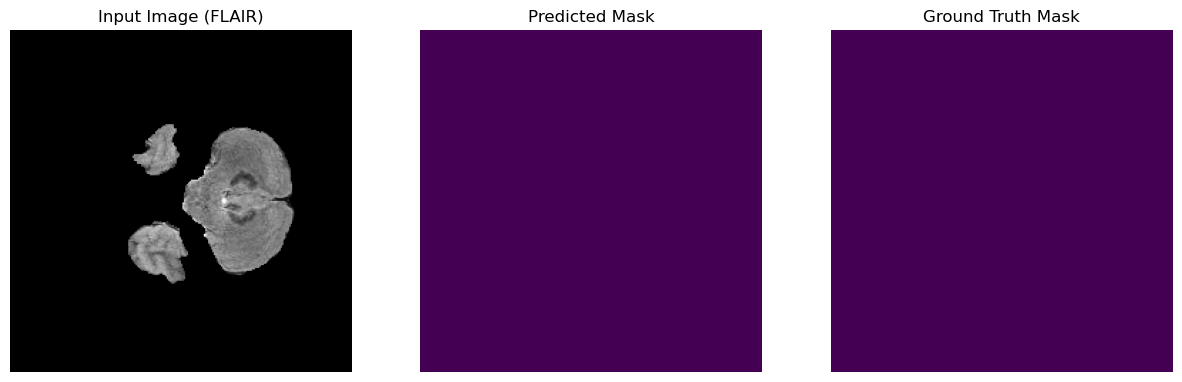

Visualizing sample at index 153 (Dice Score: 1.0000)
Index: 153, Ground Truth Sum: 0, Prediction Sum: 0


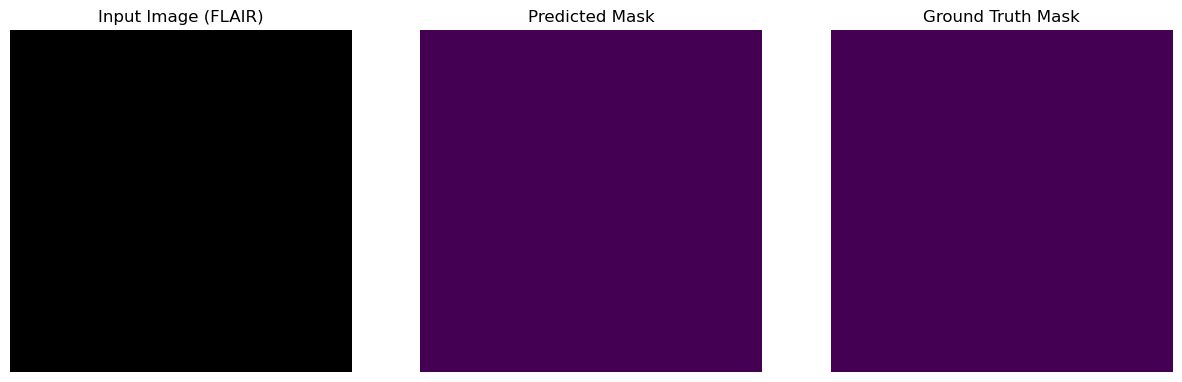

Visualizing sample at index 154 (Dice Score: 1.0000)
Index: 154, Ground Truth Sum: 0, Prediction Sum: 0


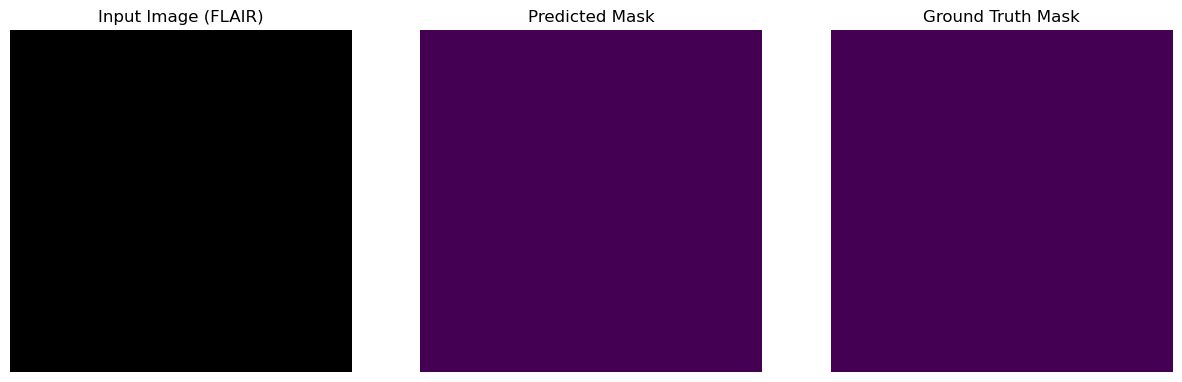

Visualizing sample at index 59 (Dice Score: 0.9809)
Index: 59, Ground Truth Sum: 1054, Prediction Sum: 1072


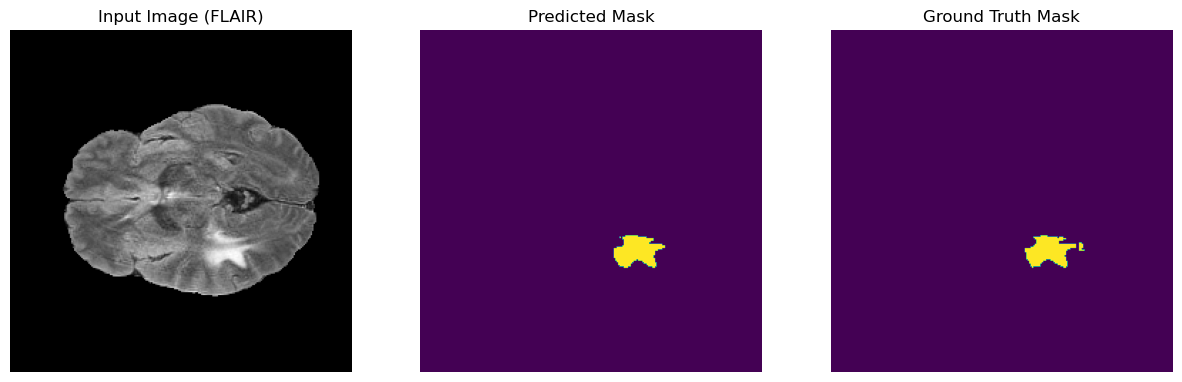

Visualizing sample at index 60 (Dice Score: 0.9805)
Index: 60, Ground Truth Sum: 1338, Prediction Sum: 1288


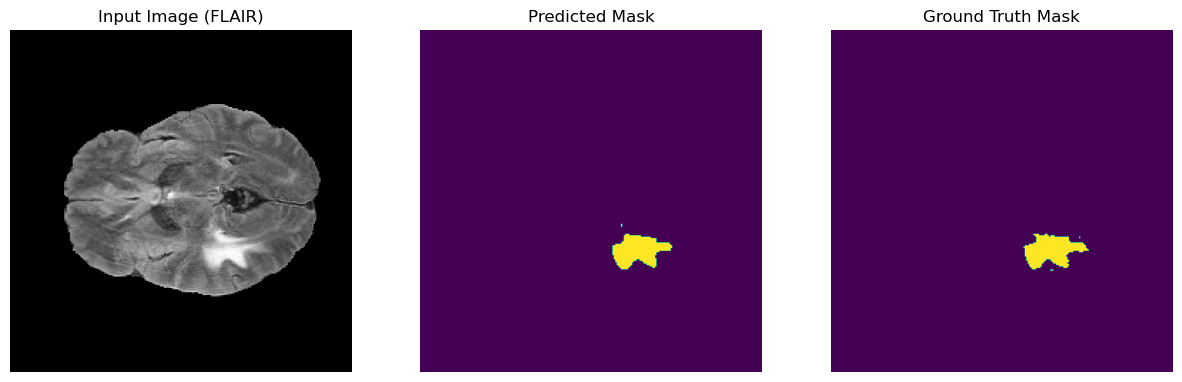

Visualizing sample at index 63 (Dice Score: 0.9796)
Index: 63, Ground Truth Sum: 2120, Prediction Sum: 2158


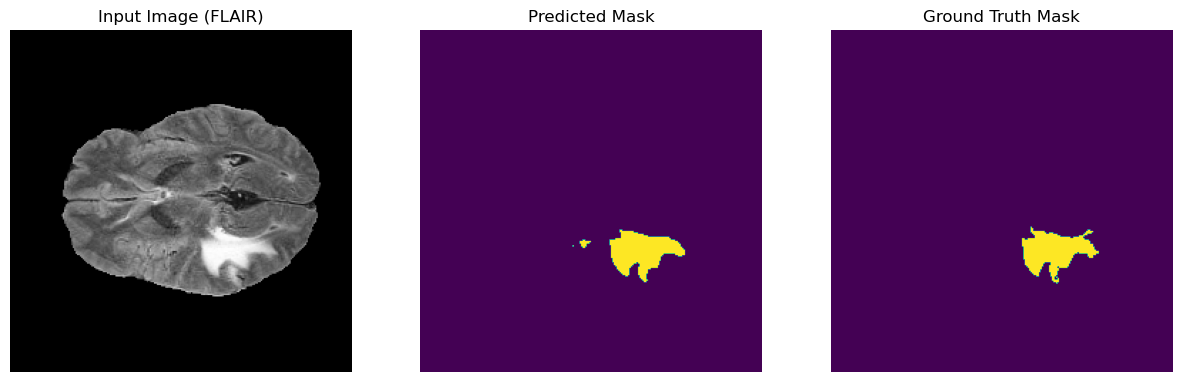

Visualizing sample at index 62 (Dice Score: 0.9756)
Index: 62, Ground Truth Sum: 1892, Prediction Sum: 1846


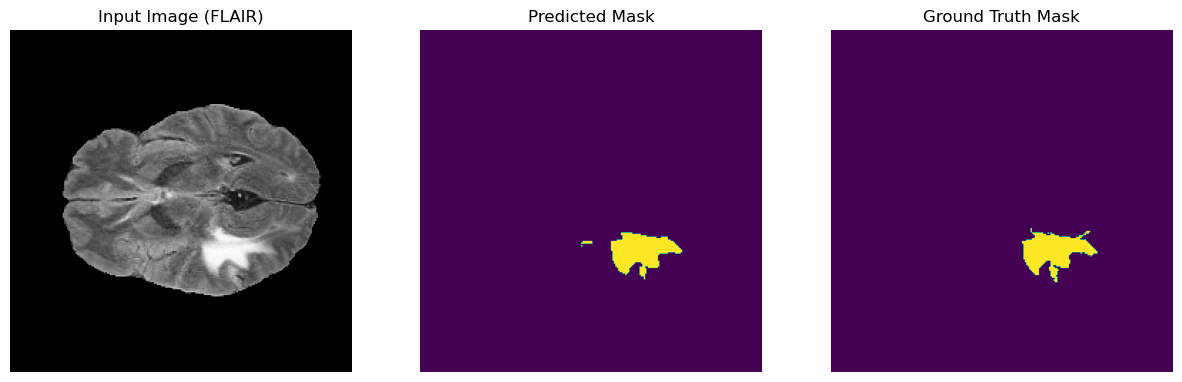

Visualizing sample at index 108 (Dice Score: 0.9697)
Index: 108, Ground Truth Sum: 1864, Prediction Sum: 2118


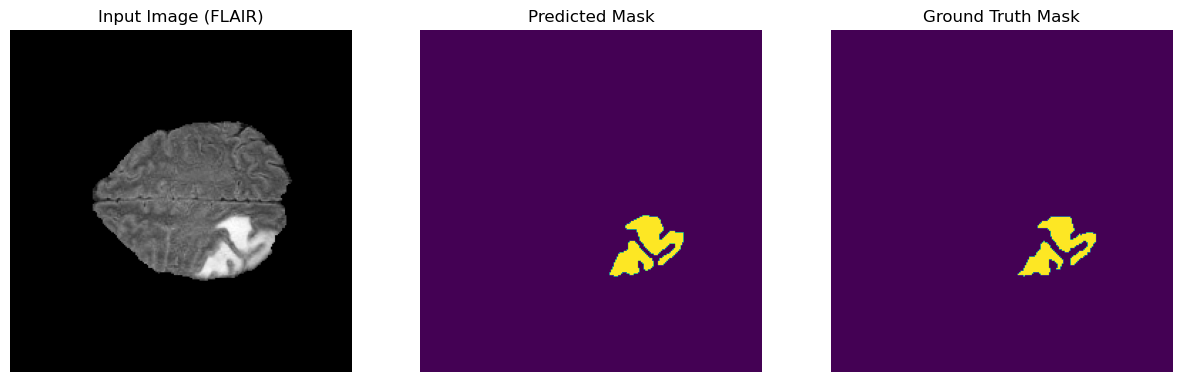

Visualizing sample at index 109 (Dice Score: 0.9653)
Index: 109, Ground Truth Sum: 1766, Prediction Sum: 2000


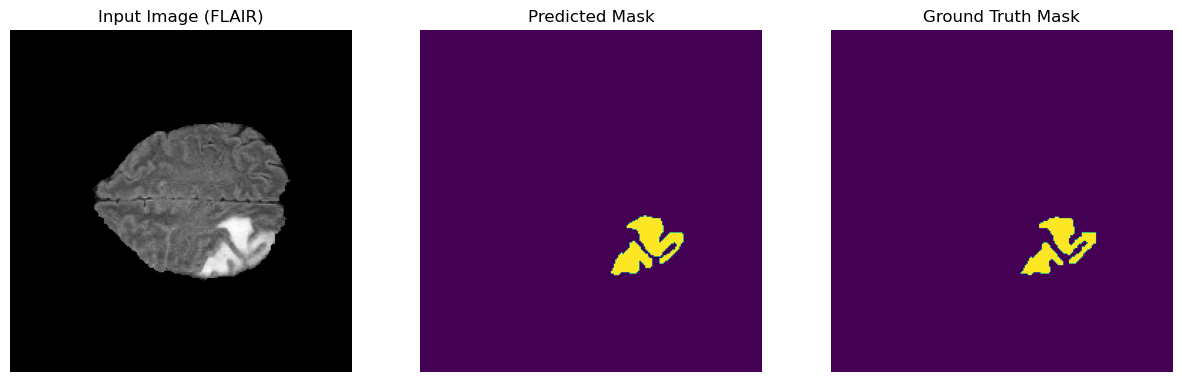

Visualizing sample at index 56 (Dice Score: 0.9627)
Index: 56, Ground Truth Sum: 268, Prediction Sum: 302


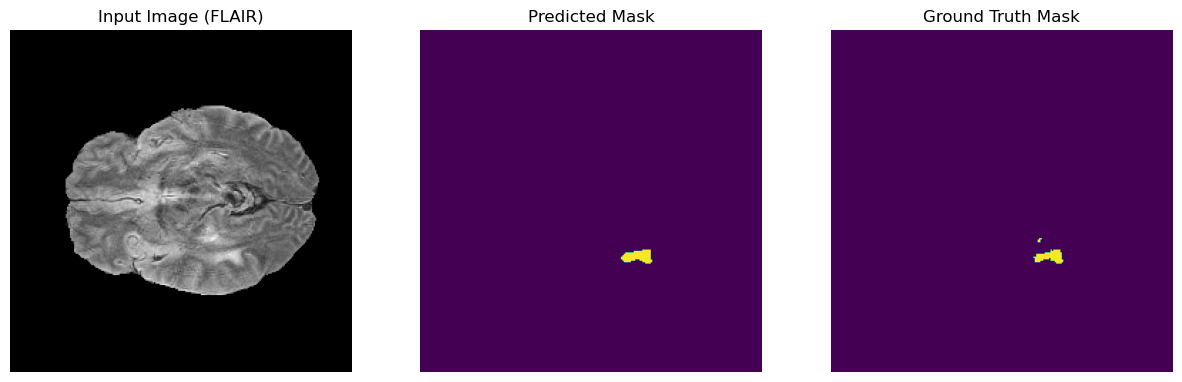

Visualizing sample at index 58 (Dice Score: 0.9601)
Index: 58, Ground Truth Sum: 748, Prediction Sum: 824


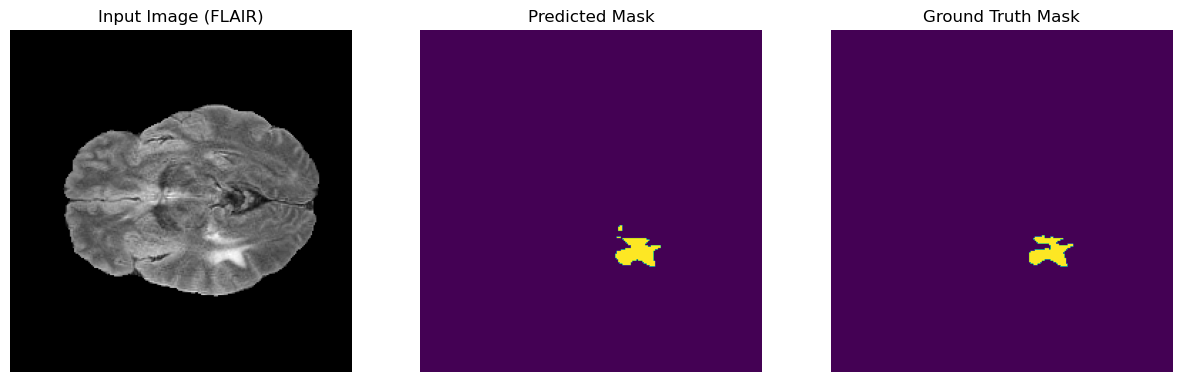

Visualizing sample at index 119 (Dice Score: 0.9562)
Index: 119, Ground Truth Sum: 88, Prediction Sum: 110


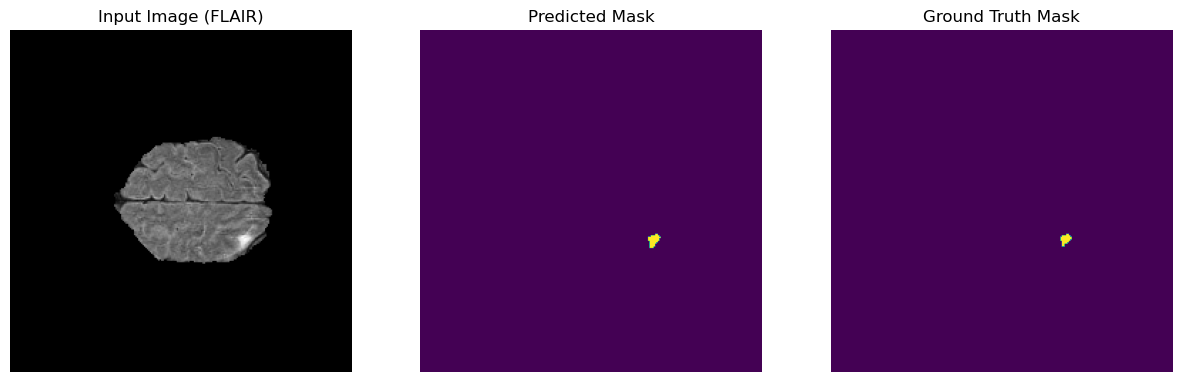

Visualizing sample at index 110 (Dice Score: 0.9558)
Index: 110, Ground Truth Sum: 1516, Prediction Sum: 1800


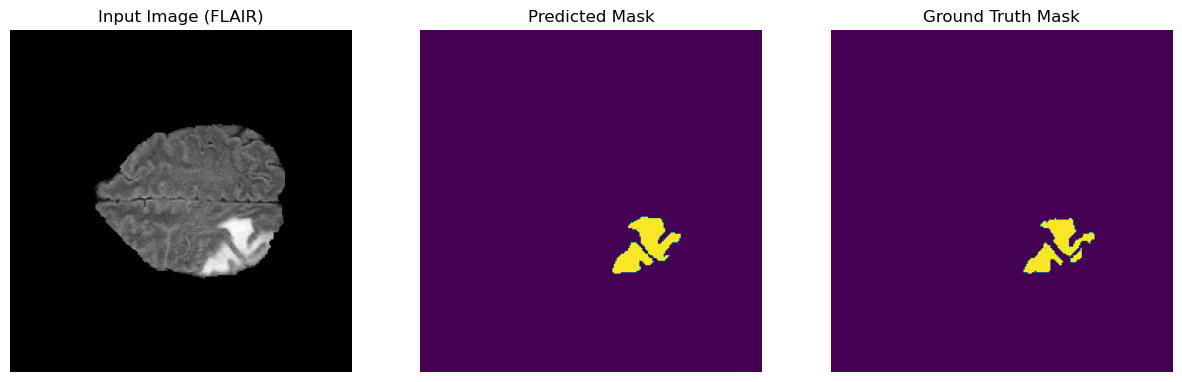

Visualizing sample at index 111 (Dice Score: 0.9526)
Index: 111, Ground Truth Sum: 1346, Prediction Sum: 1676


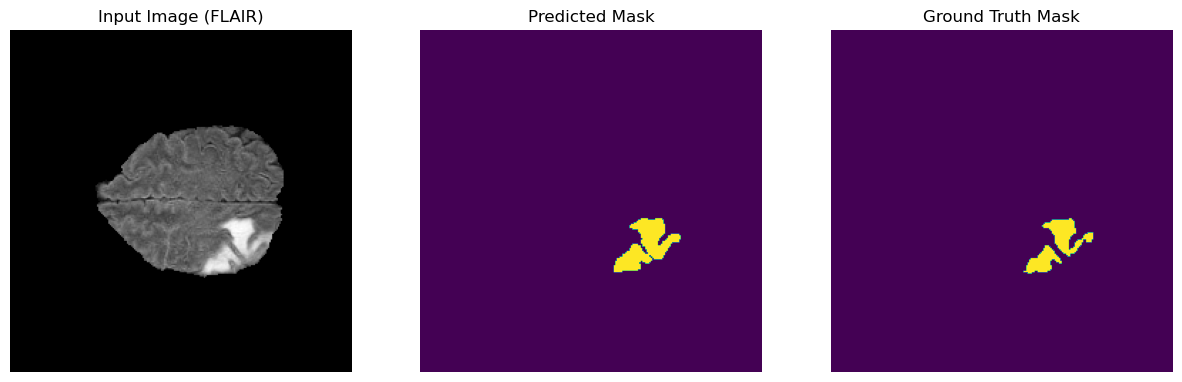

Visualizing sample at index 113 (Dice Score: 0.9523)
Index: 113, Ground Truth Sum: 1026, Prediction Sum: 1350


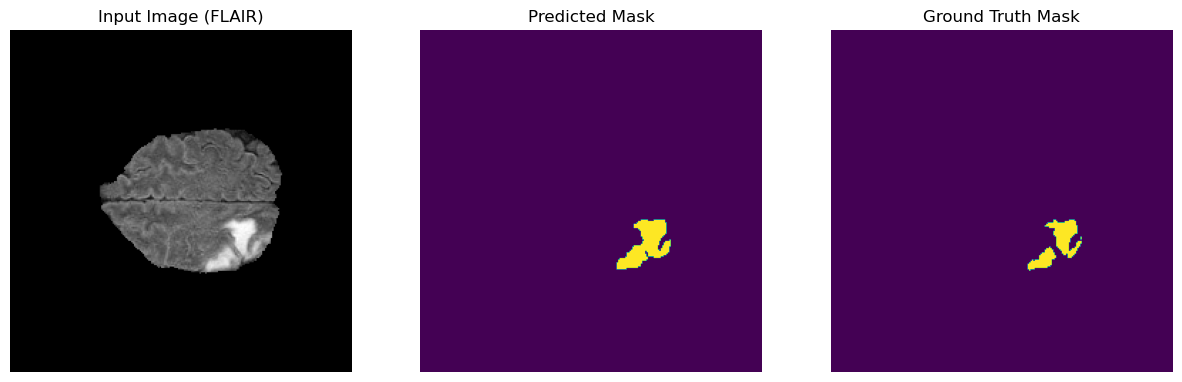

Visualizing sample at index 112 (Dice Score: 0.9472)
Index: 112, Ground Truth Sum: 1208, Prediction Sum: 1558


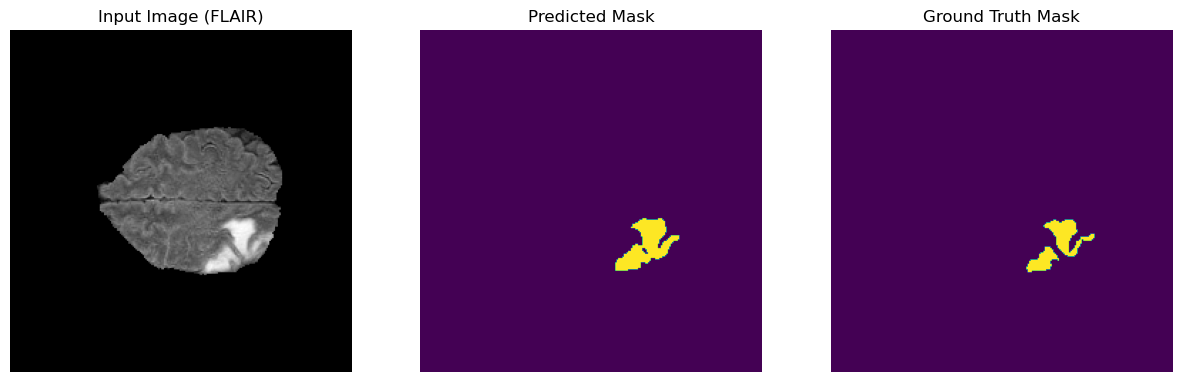

Visualizing sample at index 114 (Dice Score: 0.9423)
Index: 114, Ground Truth Sum: 812, Prediction Sum: 1152


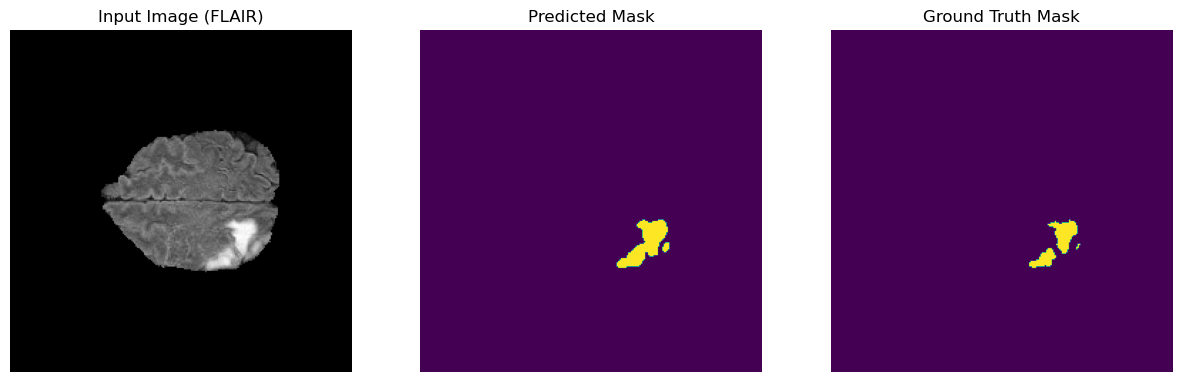

Visualizing sample at index 57 (Dice Score: 0.9384)
Index: 57, Ground Truth Sum: 466, Prediction Sum: 486


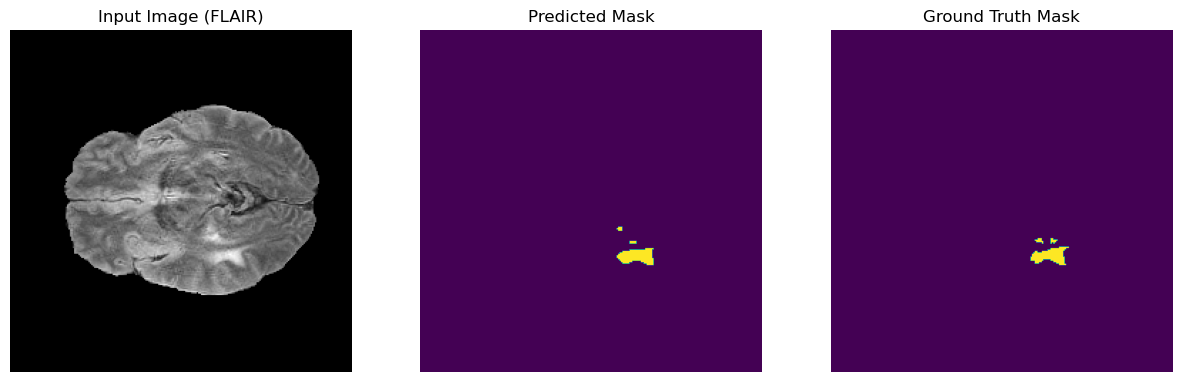

Visualizing sample at index 115 (Dice Score: 0.9351)
Index: 115, Ground Truth Sum: 662, Prediction Sum: 982


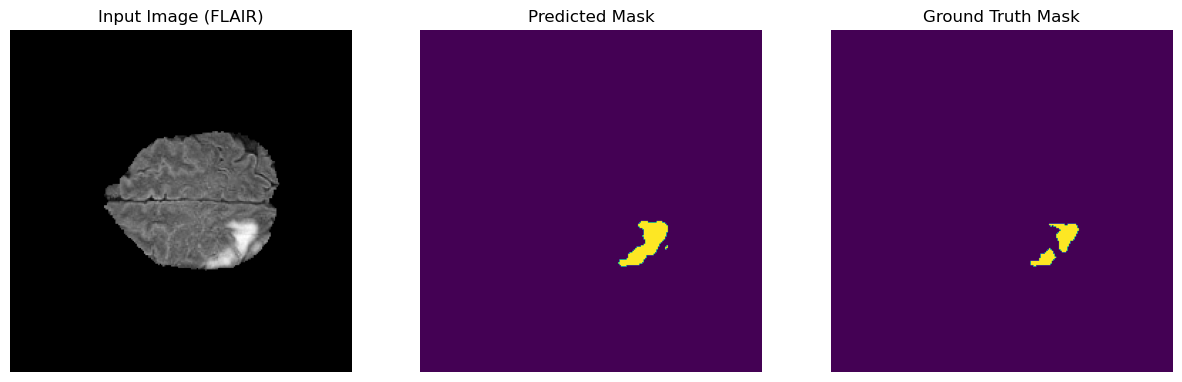

Visualizing sample at index 117 (Dice Score: 0.9151)
Index: 117, Ground Truth Sum: 280, Prediction Sum: 466


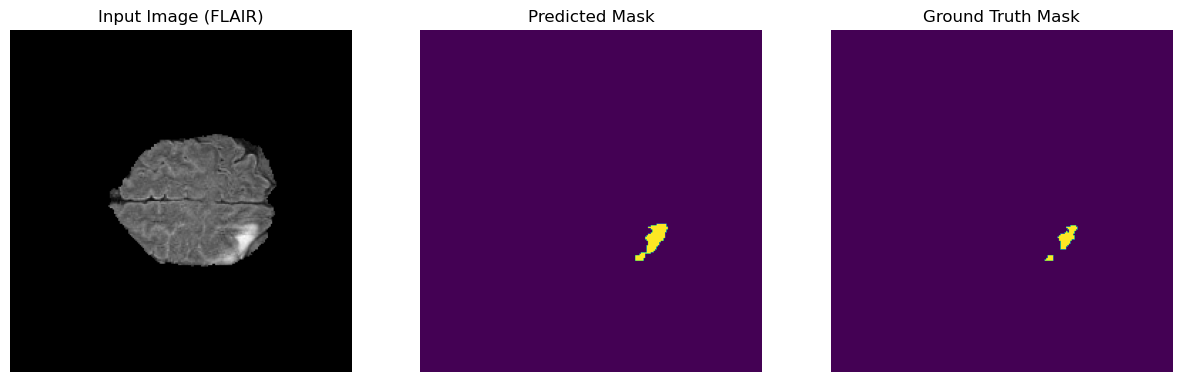

Visualizing sample at index 116 (Dice Score: 0.9032)
Index: 116, Ground Truth Sum: 422, Prediction Sum: 762


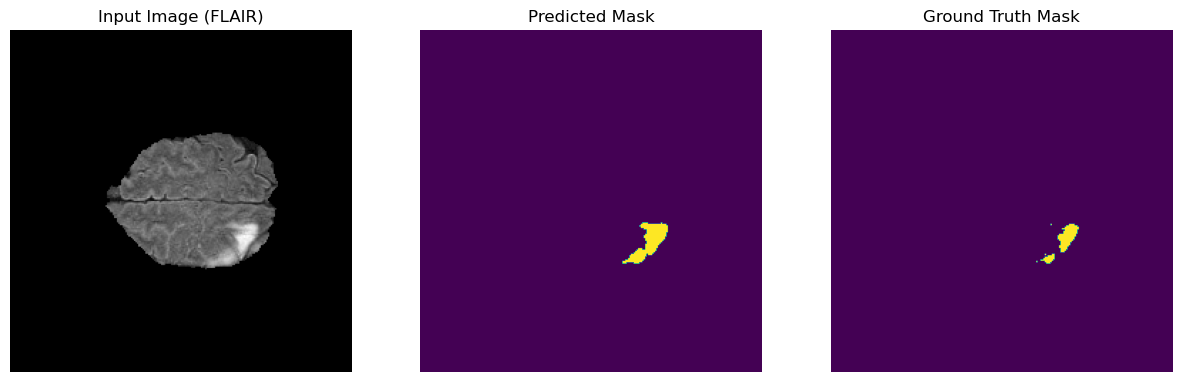

Visualizing sample at index 87 (Dice Score: 0.8992)
Index: 87, Ground Truth Sum: 5480, Prediction Sum: 5439


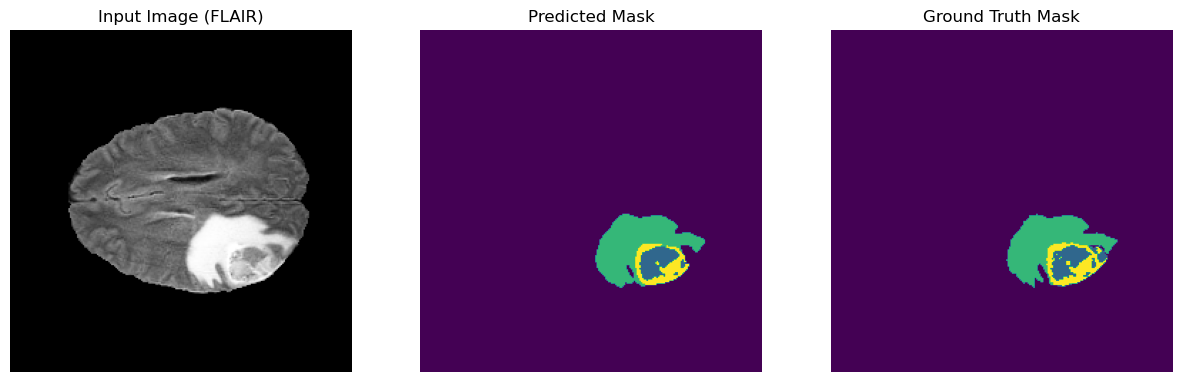

Visualizing sample at index 86 (Dice Score: 0.8886)
Index: 86, Ground Truth Sum: 5571, Prediction Sum: 5479


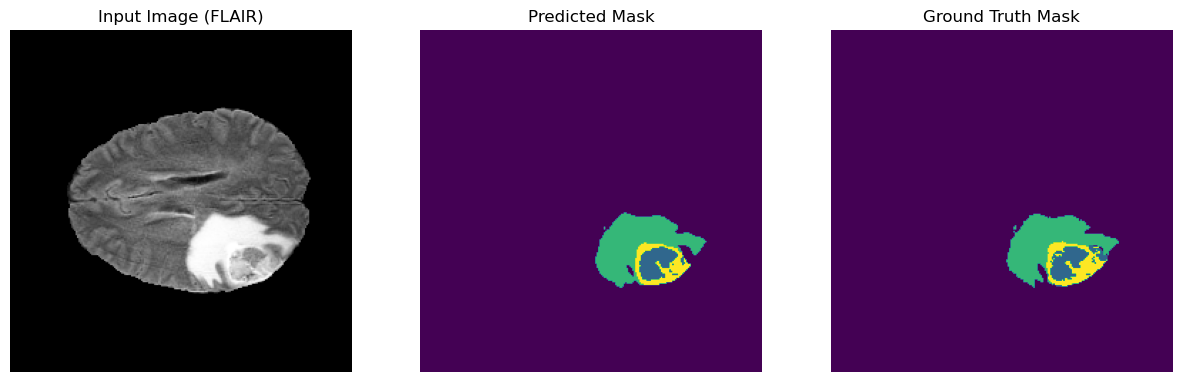

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pathlib import Path

# File paths
validation_results_path = "../exp/validation_results.csv"
csv_path = "../data/selected_test_subject.csv"

# Load validation results
validation_results = pd.read_csv(validation_results_path)

# Get the worst 10 results (lowest Dice scores)
#worst_results = validation_results.nsmallest(50, "Dice Score")
worst_results = validation_results.nlargest(100, "Dice Score")

# Load dataset
dataset = BrainSegmentationDataset(csv_path)

# Function to visualize
def visualize_sample(dataset, index, model, device):
    images, true_mask = dataset[index]
    images = images.unsqueeze(0).to(device)  # Add batch dimension
    true_mask = true_mask.cpu().numpy()

    # Get model prediction
    model.eval()
    with torch.no_grad():
        pred_mask = model(images).argmax(dim=1).squeeze(0).cpu().numpy()

    print(f"Index: {idx}, Ground Truth Sum: {true_mask.sum()}, Prediction Sum: {pred_mask.sum()}")

    # Plot the images, predicted mask, and ground truth
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(images.squeeze().cpu().numpy()[0], cmap="gray")  # Show one modality (e.g., FLAIR)
    axs[0].set_title("Input Image (FLAIR)")
    axs[0].axis("off")
    
    axs[1].imshow(pred_mask, cmap="viridis")
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")
    
    axs[2].imshow(true_mask, cmap="viridis")
    axs[2].set_title("Ground Truth Mask")
    axs[2].axis("off")
    
    plt.show()
 
# Load trained model
checkpoint_path = "../model/model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device)  # Adjust for your dataset
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)

# Visualize the worst results
for idx in worst_results["Index"]:
    print(f"Visualizing sample at index {idx} (Dice Score: {worst_results[worst_results['Index'] == idx]['Dice Score'].values[0]:.4f})")
    visualize_sample(dataset, idx, model, device)
